In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
cmap = matplotlib.colormaps.get('tab10').colors
import torch
import torch_geometric as tg
from tqdm import trange
import ipywidgets as widgets
from ipywidgets.widgets import interact

In [3]:
import numpy as np
rng = np.random.default_rng()
import os
import torch_geometric as tg
import torch
from tqdm import trange
from scipy.spatial import KDTree
import networkx as nx

class PlaneAutoencoderDataset(tg.data.Dataset):
    '''
    This class bundles the creation and saving as well as loading of a dataset of 3D graphs. If an instance is created, the class will 
    check in root directory if the dataset is already processed. If not, the process() method will be called. Furthermore, the
    dataset will be loaded. If the dataset shall be calculated again, the process() method must be called explicitely.
    '''
    def __init__(self, root, n_graphs_per_type=100, transform=None, pre_transform=None, size=(5,5)):
        '''
        Args:
        - root (str): The directory where the dataset should be stored, divided into processed and raw dirs
        '''
        self.root = root
        self.n_graphs_per_type = n_graphs_per_type
        self.size = size    
        super().__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        '''
        If this file exists in the raw directory, the download will be skipped. Download not implemented.
        '''
        return 'raw.txt'
    
    @property
    def processed_file_names(self):
        '''
        If this file exists in the processed directory, processing will be skipped. 
        Note: This does smh not work, therefore files are ATM recalculated every time.
        '''
        return ['data_00000.pt']
    
    def download(self):
        '''
        Download not implemented.
        '''
        pass
    
    def len(self):
        '''
        Returns the number of graphs in the dataset.
        '''
        return len([f for f in os.listdir(os.path.join(self.root, 'processed')) if f.startswith('data')])
    
    def get(self, idx):
        '''
        Returns the graph at index idx. 
        '''
        data = torch.load(os.path.join(self.processed_dir, 'data_{:05d}.pt'.format(idx)))
        return data
    
    def process(self):
        '''
        Here creation, processing and saving of the dataset happens. 
        '''
        planeGraph = PlaneGraphGenerator(size=self.size) # Create the planeGraph object
        for n in trange(self.n_graphs_per_type * 5):
            # Get graph features:
            pos, edge_index, label, node_attr, edge_attr = planeGraph.process_lattice(planeGraph.lattice_types[n % 5])
            
            # Create data object:
            data = tg.data.Data(x          = torch.tensor(node_attr, dtype=torch.float), 
                                edge_index = torch.tensor(edge_index, dtype=torch.int64), 
                                y          = torch.tensor(label, dtype=torch.float), 
                                pos        = torch.tensor(pos, dtype=torch.float),
                                edge_attr  = torch.tensor(edge_attr, dtype=torch.float))
            # Save data object:
            torch.save(data, os.path.join(self.processed_dir, 'data_{:05d}.pt'.format(n)))

class PlaneGraphGenerator():
    def __init__(self, size=(5,5)):
        '''
        Args:
        - size (tuple): The size of the lattice in x,y direction. The lattice will be size[0] x size[1] large.
        '''
        self.size = np.array(size) + 3
        self.lattice_types = {
            0: {'name': 'mP', 'nodes': self._get_P_nodes, 'binding_angle':   0, 'scale': [0, 0]},
            1: {'name': 'oP', 'nodes': self._get_P_nodes, 'binding_angle':  90, 'scale': [0, 0]},
            2: {'name': 'oC', 'nodes': self._get_C_nodes, 'binding_angle':  90, 'scale': [0, 0]},
            3: {'name': 'tP', 'nodes': self._get_P_nodes, 'binding_angle':  90, 'scale': [1, 1]},
            4: {'name': 'hP', 'nodes': self._get_P_nodes, 'binding_angle': 120, 'scale': [1, 1]}
        }
        
    def _get_P_nodes(self, angle=90):
        '''
        Get the nodes of a primitive lattice.
        '''
        scaling = np.sin(np.radians(angle))
        vec1 = np.arange(0,self.size[0])
        vec2 = np.arange(0,self.size[1])*scaling
        a, b = np.meshgrid(vec1,vec2)
        nodes = np.stack([a,b],axis=-1) # Stack them in a new axis
        nodes = np.reshape(nodes, (-1, 2)) # Reshape to an arr of nodes with shape (#nodes, 2)
        return nodes

    def _get_C_nodes(self):
        '''
        Get the nodes of a centred lattice.
        '''
        P = self._get_P_nodes()
        extra = P + np.array([0.5,0.5])
        return np.row_stack((P, extra))
    

    def process_lattice(self, arg_dict):
        '''
        Method that processes a lattice of a given type. The method is called with a dictionary holding parameters for one of the lattice types. It contains the following keys:
            - name: The name of the lattice type
            - nodes: The method to get the fitting fundamental lattice nodes
            - binding_angle: binding angle alpha of the lattice type. angle are in degrees. 0° means to generate a independent random angle (0,180)°
            - scale: A list of scaling factors [x,y] for the lattice type. 0 means to generate a random scaling factor (0,2)
        '''
        # Get lattice angles
        angle = arg_dict['binding_angle']
        if angle == 0:
            angle = rng.uniform(46,89,1)
            
        # Get the fundamental lattice nodes
        if arg_dict['name'] in ['hP']:
            # For hP lattice we need to give the angle to the nodes method so that sheared connections are equally long
            nodes = arg_dict['nodes'](angle)
        else:
            nodes = arg_dict['nodes']()
        inside_mask = self._get_inside_mask(nodes)
        nodes = self._shear_nodes(nodes, angle)
        # Find random scale and apply gaussian noise to the lattice accordingly
        scale = np.array(arg_dict['scale'])
        scale = np.where(scale == 0, rng.uniform(0.3,3,2), scale)
        noise_level = 0.05 / scale  # At this step we scale the noise down, so that the scaling later on does not affect the noise level
        #nodes += rng.normal(0, noise_level, nodes.shape)
        
        nodes, labels, inside_mask = self._displace_node(nodes, inside_mask)
        # Find the connections between the nodes in a given radius
        cons= self._get_cons_in_radius(nodes, 1.3+np.mean(noise_level))
        # Apply the saved scaling
        nodes *= scale
        
        node_attr = self.get_node_attr(nodes, cons)
        nodes, labels, node_attr = nodes[inside_mask], labels[inside_mask], node_attr[inside_mask]
        cons = self._get_cons_in_radius(nodes, 1.3+np.mean(noise_level))
        edge_attr = self.get_edge_attr(nodes, cons)
        return nodes, cons, labels, node_attr, edge_attr

    def _displace_node(self, nodes, inside_mask):
        '''
        Method that dislaces one random node in the lattice by a random amount. Returns the new nodes and the label for classification. 
        The label is a one hot encoded array of shape (len(nodes)) where 1 markes the index od the displaced node.
        '''
        # Get random inside node 
        allowed_indices = np.where(inside_mask)[0]
        node_ind = rng.choice(allowed_indices)
        # Get random displacement
        displacement = rng.normal(0, 1, 2)
        # Assert that the displacement does not move the node out of the lattice (roughly)
        while np.any(nodes[node_ind] + displacement < np.min(nodes[inside_mask], axis=0)) or np.any(nodes[node_ind] + displacement > np.max(nodes[inside_mask], axis=0)):
            displacement = rng.normal(0, 1, 2)
        # Displace node, get label
        nodes = np.insert(nodes, node_ind, nodes[node_ind] + displacement, axis=0)
        inside_mask = np.insert(inside_mask, node_ind, True)
        #nodes[node_ind] += displacement
        labels = np.zeros(len(nodes))
        labels[node_ind] = 1
        return nodes, labels.reshape(-1,1), inside_mask
    
    def _get_cons_in_radius(self, nodes, radius):
        '''
        Get the connections in a radius as well as the total number of cons for each node.
        '''
        tree = KDTree(nodes)
        cons = tree.query_pairs(radius, output_type='ndarray', p=2)
        cons = cons.T
        cons = np.column_stack((cons, cons[::-1])) # Add the reverse connections
        return cons

    def _shear_nodes(self, nodes, binding_angle):
        '''
        Shear nodes by binding angle.
        '''
        delta = np.tan(np.radians(binding_angle))
        assert not np.any(delta == 0), 'Binding angle cannot be 0'
        nodes = nodes.astype(float)
        nodes = nodes + np.stack((nodes[:,1]/delta, np.zeros_like(nodes[:,1])), axis=1)
        return nodes

    def _add_defects(self, nodes, edge_index, labels):
        '''
        Method that adds up to 10% of random defects (i.e. missing nodes) to the lattice. Should be called after _get_*_graph() but before
        _get_edge_attr() and _get_node_attr().
        '''
        # Draw up to 10% of unique random indices for nodes to be removed
        drop_indices = rng.choice(np.arange(len(nodes)), rng.integers(len(nodes)//10), replace=False)
        # Remove the nodes and labels
        nodes = np.delete(nodes, drop_indices, axis=0)
        labels = np.delete(labels, drop_indices, axis=0)
        # Delete every connection that refers to a removed node
        edge_index = np.delete(edge_index, np.where(np.isin(edge_index, drop_indices))[1], axis=1)
        
        # As edge_index refers to the original node indices, we need to adjust the indices of most connections
        # For this we create a mapping from old indices to new indices
        old_to_new = np.arange(len(nodes) + len(drop_indices))  # Start with an array of original indices; [0,1,2,3,4,5,...]
        old_to_new[drop_indices] = -1  # Mark the indices of the nodes to be deleted; eg. drop_indices = [1,3] -> [0,-1,2,-1,4,5,...]
        old_to_new = np.cumsum(old_to_new != -1) - 1  # Create a cumulative sum array; cumsum([True, False, True, False, True, True,...]) -1 -> [1,1,2,2,3,4,...] -1 -> [0,0,1,1,2,3,...]
        
        # # Update edge indices to reflect new node indices through broadcasting
        edge_index = old_to_new[edge_index]
        return nodes, edge_index, labels
        
    def get_node_attr(self,nodes,cons):
        '''
        Method that returns the node attributes for each node in the graph. Should be called after creating the graph and adding defects.
        The node attributes have the shape (num_nodes, num_node_features). For each node, the node features are the following:
        - The bond orientational order parameters for l=4,6,8,10 (4 features)
        '''
        G = nx.Graph()
        G.add_edges_from(cons.T)
        boo_arr = np.zeros((len(nodes), 5), dtype=complex)
        n_neighbors = np.zeros(len(nodes))
        for i in range(len(nodes)):
            if i not in G.nodes:
                # node is not connected to any other node, return 0
                boo_arr[i] = np.zeros(5)
                n_neighbors[i] = 0
                continue
            # iterate over all nodes, get their neighbors
            neighbors = list(G.neighbors(i))
            n_neighbors[i] = len(neighbors)
            # calculate the bond orientational order parameters
            boo_ = np.zeros(5, dtype=complex)
            for n in neighbors:
                angle = np.arctan2(nodes[n,1] - nodes[i,1], nodes[n,0] - nodes[i,0])
                boo_ += np.array([np.exp(1j*2*angle), np.exp(1j*4*angle), np.exp(1j*6*angle), np.exp(1j*8*angle), np.exp(1j*10*angle)])   
            boo_arr[i] = np.abs(boo_ / len(neighbors)) 
        boo_arr = np.real(boo_arr)
        # return boo_arr
        return np.column_stack((boo_arr, n_neighbors))
        
    
    def get_edge_attr(self,nodes,cons):
        '''
        Method that returns the edge attributes for each edge in the graph. Should be called after creating the graph and adding defects.
        Returns an array of shape (len(edge_index[0])= #Edges, 1) with the length of each edge.
        '''
        # Get the edge vectors for each edge
        edge_vectors = nodes[cons[0]] - nodes[cons[1]]
        return np.linalg.norm(edge_vectors, axis=1).reshape(-1,1)   
    
    def _get_inside_mask(self, nodes):
        '''
        Method that returns the indices of the border nodes of the lattice. 
        '''
        mask = np.any(np.logical_or(nodes < np.array([1,1]), nodes >= self.size-2), axis=1)
        return ~mask
 


def plot(nodes, cons, labels=None, scores=None):
    '''
    Plot the graph.
    '''
    fig, ax = plt.subplots()
    ax.scatter(nodes[:,0], nodes[:,1], c='black')
    for con in cons.T:
        ax.plot(nodes[con,0], nodes[con,1], c='black')
    labels = labels.flatten()
    if labels is not None:
        ax.plot(nodes[labels==1,0], nodes[labels==1,1], c='red', markersize=10, marker='o', linestyle='None')
    if scores is not None:
        ax.plot(nodes[np.argmax(scores),0], nodes[np.argmax(scores),1], c='blue', markersize=10, marker='x')
    ax.set_aspect('equal')
    ax.grid()

In [4]:
n = 250
dataset = PlaneAutoencoderDataset("autoencoder_2d", n_graphs_per_type=n, size=(10,10))
# delete the processed folder when you want to recalculate the dataset
# import shutil
# shutil.rmtree("autoencoder_2d/processed")
# dataset.process()
dataset[0]

C:\Users\steph\AppData\Local\Temp\ipykernel_18292\1499384556.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, 'data_{:

Data(x=[101, 6], edge_index=[2, 188], edge_attr=[188, 1], y=[101, 1], pos=[101, 2])

## NN cell

In [10]:
train_loader = tg.loader.DataLoader(dataset[:n*4], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[n*4:], batch_size=16, shuffle=True)
device= 'cuda' if torch.cuda.is_available() else 'cpu'
num_features = dataset.num_features
alpha = 0.5 # weight of the attribute loss


class dominant(torch.nn.Module):
    def __init__(self):
        super(dominant, self).__init__()
        self.encoder = torch.nn.ModuleList()
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(num_features, 4), edge_dim=1))
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(4, 3), edge_dim=1))
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(3, 2), edge_dim=1))

        self.attr_decoder =torch.nn.ModuleList()
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(2, 3), edge_dim=1))
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(3, 4), edge_dim=1))
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(4, num_features), edge_dim=1))

        self.dropout = torch.nn.Dropout()  
    def forward(self, x, edge_index, edge_attr):
        z = self.encoder[0](x, edge_index, edge_attr).sigmoid()
        for layer in self.encoder[1:]:
            z = layer(z, edge_index, edge_attr).sigmoid()
            z = self.dropout(z)
        # decoder
        adj_ = z @ z.T # structure decoder
        x_ = self.attr_decoder[0](z, edge_index, edge_attr).sigmoid()
        for layer in self.attr_decoder[1:-1]:
            x_ = layer(x_, edge_index, edge_attr).sigmoid()
            x_ = self.dropout(x_)
        x_ = self.attr_decoder[-1](x_, edge_index, edge_attr)
        return x_, adj_

model = dominant()
model.to(device)
print(model)

def loss_func(x, x_, adj, adj_):
    #adj = adj.type(torch.float)
    return alpha * torch.linalg.norm(x-x_, ord='fro') + (1-alpha) * torch.linalg.norm(adj - adj_, ord='fro')

def train(loader):
    model.train()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)

        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        counter += 1
    return avg_loss / counter
def test(loader):
    model.eval()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)
        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
        avg_loss += loss.item()
        counter += 1
    return avg_loss / counter

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

dominant(
  (encoder): ModuleList(
    (0): GINEConv(nn=Linear(in_features=4, out_features=4, bias=True))
    (1): GINEConv(nn=Linear(in_features=4, out_features=3, bias=True))
    (2): GINEConv(nn=Linear(in_features=3, out_features=2, bias=True))
  )
  (attr_decoder): ModuleList(
    (0): GINEConv(nn=Linear(in_features=2, out_features=3, bias=True))
    (1): GINEConv(nn=Linear(in_features=3, out_features=4, bias=True))
    (2): GINEConv(nn=Linear(in_features=4, out_features=4, bias=True))
  )
  (dropout): Dropout(p=0.5, inplace=False)
)


C:\Users\steph\AppData\Local\Temp\ipykernel_16496\152193761.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, 'data_{:0

In [4]:
def plot_boo(nodes, boo, which=0, labels=None, scores=None):
    fig, ax = plt.subplots()
    cbar = ax.scatter(nodes[:,0], nodes[:,1], c=boo[:,which], cmap='viridis')
    # show colorbar
    fig.colorbar(cbar, shrink=0.6)
    labels = labels.flatten()
    if labels is not None:
        ax.plot(nodes[labels==1,0], nodes[labels==1,1], c='black', markersize=10, marker='+')
    if scores is not None:
        ax.plot(nodes[np.argmax(scores),0], nodes[np.argmax(scores),1], c='red', markersize=10, marker='x')
    ax.set_aspect('equal')
    ax.grid()
    #plt.show()
def anomaly_score(x, x_, adj, adj_):
    return alpha * torch.linalg.norm(x-x_, dim=1) + (1-alpha) * torch.linalg.norm(adj-adj_, dim=1)

# Start

In [7]:
train_loader = tg.loader.DataLoader(dataset[:n*4], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[n*4:], batch_size=16, shuffle=True)
device= 'cuda' if torch.cuda.is_available() else 'cpu'
num_features = dataset.num_features
alpha = 0.5 # weight of the attribute loss


class dominant(torch.nn.Module):
    def __init__(self):
        super(dominant, self).__init__()
        self.encoder = torch.nn.ModuleList()
        self.encoder.append(tg.nn.GCNConv(num_features, 4))
        self.encoder.append(tg.nn.GCNConv(4,3))
        self.encoder.append(tg.nn.GCNConv(3,2))

        self.attr_decoder =torch.nn.ModuleList()
        self.attr_decoder.append(tg.nn.GCNConv(2,3))
        self.attr_decoder.append(tg.nn.GCNConv(3,4))
        self.attr_decoder.append(tg.nn.GCNConv(4,num_features))

        self.dropout = torch.nn.Dropout()  
    def forward(self, x, edge_index):
        z = self.encoder[0](x, edge_index).relu()
        for layer in self.encoder[1:]:
            z = layer(z, edge_index).relu()
            z = self.dropout(z)
        # decoder
        adj_ = torch.relu(z @ z.T) # structure decoder
        x_ = self.attr_decoder[0](z, edge_index).relu()
        for layer in self.attr_decoder[1:-1]:
            x_ = layer(x_, edge_index).relu()
            x_ = self.dropout(x_)
        x_ = self.attr_decoder[-1](x_, edge_index)
        return x_, adj_

model = dominant()
model.to(device)
print(model)

def loss_func(x, x_, adj, adj_):
    #adj = adj.type(torch.float)
    return alpha * torch.linalg.norm(x-x_, ord='fro') + (1-alpha) * torch.linalg.norm(adj - adj_, ord='fro')

def train(loader):
    model.train()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index)

        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_))[0], adj)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        counter += 1
    return avg_loss / counter
def test(loader):
    model.eval()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index)
        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_))[0], adj)
        avg_loss += loss.item()
        counter += 1
    return avg_loss / counter
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

test_index = 21
msg = 'GCNConv, alpha 0.5, struct 6432 (k=2,4,6,8,10;NN), attr act relu, struct act relu, no square, add dropout, lr 0.001'
for i in range(5):    
    model = dominant()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 50
    train_losses = []
    test_losses = []
    score_list = []
    print('Initial Test Loss: {:.3f}'.format(test(test_loader)))
    for epoch in range(1, epochs+1):
        loss = train(train_loader)
        train_losses.append(loss)
        test_loss = test(test_loader)
        test_losses.append(test_loss)
        print(f'Epoch: {epoch:03d}')
        print('\tTraining Loss: {:.3f}'.format(loss))
        print('\tTest Loss: {:.3f}'.format(test_loss))
        model.eval()
        # Score calculation
        score = 0
        for data in test_loader.dataset:
            x_, adj = model.forward(data.x.to(device), data.edge_index.to(device))
            scores = anomaly_score(data.x.to(device), x_.to(device), tg.utils.to_dense_adj(data.edge_index.to(device), max_num_nodes=len(x_))[0], adj)
            if torch.argmax(data.y.to(device)) in torch.topk(scores, k=5)[1]:
                score += 1
        score_list.append(score / len(test_loader.dataset))
        print(score/ len(test_loader.dataset))
        np.savetxt(f'results_2d_autoencoder/test_{test_index}_iter_{i}.txt', np.column_stack((train_losses, test_losses, score_list)), header=f'train_loss test_loss score; {msg}')

C:\Users\steph\AppData\Local\Temp\ipykernel_17660\1499384556.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, 'data_{:

dominant(
  (encoder): ModuleList(
    (0): GCNConv(6, 4)
    (1): GCNConv(4, 3)
    (2): GCNConv(3, 2)
  )
  (attr_decoder): ModuleList(
    (0): GCNConv(2, 3)
    (1): GCNConv(3, 4)
    (2): GCNConv(4, 6)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)
Initial Test Loss: 181.071
Epoch: 001
	Training Loss: 183.672
	Test Loss: 179.260
0.64
Epoch: 002
	Training Loss: 181.158
	Test Loss: 174.797
0.636
Epoch: 003
	Training Loss: 177.746
	Test Loss: 172.974
0.644
Epoch: 004
	Training Loss: 174.009
	Test Loss: 168.813
0.644
Epoch: 005
	Training Loss: 170.832
	Test Loss: 164.863
0.656
Epoch: 006
	Training Loss: 166.492
	Test Loss: 160.698
0.684
Epoch: 007
	Training Loss: 162.474
	Test Loss: 156.568
0.696
Epoch: 008
	Training Loss: 158.502
	Test Loss: 152.358
0.716
Epoch: 009
	Training Loss: 153.150
	Test Loss: 146.818
0.72
Epoch: 010
	Training Loss: 148.986
	Test Loss: 142.065
0.72
Epoch: 011
	Training Loss: 144.273
	Test Loss: 136.179
0.724
Epoch: 012
	Training Loss: 139.599
	Test Loss: 13

In [8]:
train_loader = tg.loader.DataLoader(dataset[:n*4], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[n*4:], batch_size=16, shuffle=True)
device= 'cuda' if torch.cuda.is_available() else 'cpu'
num_features = dataset.num_features
alpha = 0.5 # weight of the attribute loss


class dominant(torch.nn.Module):
    def __init__(self):
        super(dominant, self).__init__()
        self.encoder = torch.nn.ModuleList()
        self.encoder.append(tg.nn.GCNConv(num_features, 5))
        self.encoder.append(tg.nn.GCNConv(5,4))
        self.encoder.append(tg.nn.GCNConv(4,3))

        self.attr_decoder =torch.nn.ModuleList()
        self.attr_decoder.append(tg.nn.GCNConv(3,4))
        self.attr_decoder.append(tg.nn.GCNConv(4,5))
        self.attr_decoder.append(tg.nn.GCNConv(5,num_features))

        self.dropout = torch.nn.Dropout()  
    def forward(self, x, edge_index):
        z = self.encoder[0](x, edge_index).relu()
        for layer in self.encoder[1:]:
            z = layer(z, edge_index).relu()
            z = self.dropout(z)
        # decoder
        adj_ = torch.relu(z @ z.T) # structure decoder
        x_ = self.attr_decoder[0](z, edge_index).relu()
        for layer in self.attr_decoder[1:-1]:
            x_ = layer(x_, edge_index).relu()
            x_ = self.dropout(x_)
        x_ = self.attr_decoder[-1](x_, edge_index)
        return x_, adj_

model = dominant()
model.to(device)
print(model)

def loss_func(x, x_, adj, adj_):
    #adj = adj.type(torch.float)
    return alpha * torch.linalg.norm(x-x_, ord='fro') + (1-alpha) * torch.linalg.norm(adj - adj_, ord='fro')

def train(loader):
    model.train()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index)

        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_))[0], adj)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        counter += 1
    return avg_loss / counter
def test(loader):
    model.eval()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index)
        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_))[0], adj)
        avg_loss += loss.item()
        counter += 1
    return avg_loss / counter
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

test_index = 22
msg = 'GCNConv, alpha 0.5, struct 6543 (k=2,4,6,8,10;NN), attr act relu, struct act relu, no square, add dropout, lr 0.001'
for i in range(5):    
    model = dominant()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 50
    train_losses = []
    test_losses = []
    score_list = []
    print('Initial Test Loss: {:.3f}'.format(test(test_loader)))
    for epoch in range(1, epochs+1):
        loss = train(train_loader)
        train_losses.append(loss)
        test_loss = test(test_loader)
        test_losses.append(test_loss)
        print(f'Epoch: {epoch:03d}')
        print('\tTraining Loss: {:.3f}'.format(loss))
        print('\tTest Loss: {:.3f}'.format(test_loss))
        model.eval()
        # Score calculation
        score = 0
        for data in test_loader.dataset:
            x_, adj = model.forward(data.x.to(device), data.edge_index.to(device))
            scores = anomaly_score(data.x.to(device), x_.to(device), tg.utils.to_dense_adj(data.edge_index.to(device), max_num_nodes=len(x_))[0], adj)
            if torch.argmax(data.y.to(device)) in torch.topk(scores, k=5)[1]:
                score += 1
        score_list.append(score / len(test_loader.dataset))
        print(score/ len(test_loader.dataset))
        np.savetxt(f'results_2d_autoencoder/test_{test_index}_iter_{i}.txt', np.column_stack((train_losses, test_losses, score_list)), header=f'train_loss test_loss score; {msg}')

dominant(
  (encoder): ModuleList(
    (0): GCNConv(6, 5)
    (1): GCNConv(5, 4)
    (2): GCNConv(4, 3)
  )
  (attr_decoder): ModuleList(
    (0): GCNConv(3, 4)
    (1): GCNConv(4, 5)
    (2): GCNConv(5, 6)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)


C:\Users\steph\AppData\Local\Temp\ipykernel_17660\1499384556.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, 'data_{:

Initial Test Loss: 6559.498
Epoch: 001
	Training Loss: 9343.008
	Test Loss: 1866.336
0.684
Epoch: 002
	Training Loss: 3346.408
	Test Loss: 833.845
0.652
Epoch: 003
	Training Loss: 1560.286
	Test Loss: 433.534
0.664
Epoch: 004
	Training Loss: 796.849
	Test Loss: 269.183
0.64
Epoch: 005
	Training Loss: 461.729
	Test Loss: 200.419
0.636
Epoch: 006
	Training Loss: 297.173
	Test Loss: 176.512
0.636
Epoch: 007
	Training Loss: 223.710
	Test Loss: 167.884
0.648
Epoch: 008
	Training Loss: 192.383
	Test Loss: 163.982
0.66
Epoch: 009
	Training Loss: 176.264
	Test Loss: 159.318
0.676
Epoch: 010
	Training Loss: 166.238
	Test Loss: 153.446
0.684
Epoch: 011
	Training Loss: 158.153
	Test Loss: 146.555
0.684
Epoch: 012
	Training Loss: 150.156
	Test Loss: 137.470
0.704
Epoch: 013
	Training Loss: 140.377
	Test Loss: 128.130
0.716
Epoch: 014
	Training Loss: 131.989
	Test Loss: 117.192
0.716
Epoch: 015
	Training Loss: 124.997
	Test Loss: 108.977
0.732
Epoch: 016
	Training Loss: 120.122
	Test Loss: 100.730


In [9]:
train_loader = tg.loader.DataLoader(dataset[:n*4], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[n*4:], batch_size=16, shuffle=True)
device= 'cuda' if torch.cuda.is_available() else 'cpu'
num_features = dataset.num_features
alpha = 0.5 # weight of the attribute loss


class dominant(torch.nn.Module):
    def __init__(self):
        super(dominant, self).__init__()
        self.encoder = torch.nn.ModuleList()
        self.encoder.append(tg.nn.GCNConv(num_features, 5))
        self.encoder.append(tg.nn.GCNConv(5,3))
        self.encoder.append(tg.nn.GCNConv(3,1))

        self.attr_decoder =torch.nn.ModuleList()
        self.attr_decoder.append(tg.nn.GCNConv(1,3))
        self.attr_decoder.append(tg.nn.GCNConv(3,5))
        self.attr_decoder.append(tg.nn.GCNConv(5,num_features))

        self.dropout = torch.nn.Dropout()  
    def forward(self, x, edge_index):
        z = self.encoder[0](x, edge_index).relu()
        for layer in self.encoder[1:]:
            z = layer(z, edge_index).relu()
            z = self.dropout(z)
        # decoder
        adj_ = torch.relu(z @ z.T) # structure decoder
        x_ = self.attr_decoder[0](z, edge_index).relu()
        for layer in self.attr_decoder[1:-1]:
            x_ = layer(x_, edge_index).relu()
            x_ = self.dropout(x_)
        x_ = self.attr_decoder[-1](x_, edge_index)
        return x_, adj_

model = dominant()
model.to(device)
print(model)

def loss_func(x, x_, adj, adj_):
    #adj = adj.type(torch.float)
    return alpha * torch.linalg.norm(x-x_, ord='fro') + (1-alpha) * torch.linalg.norm(adj - adj_, ord='fro')

def train(loader):
    model.train()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index)

        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_))[0], adj)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        counter += 1
    return avg_loss / counter
def test(loader):
    model.eval()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index)
        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_))[0], adj)
        avg_loss += loss.item()
        counter += 1
    return avg_loss / counter
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

test_index = 23
msg = 'GCNConv, alpha 0.5, struct 6531 (k=2,4,6,8,10;NN), attr act relu, struct act relu, no square, add dropout, lr 0.001'
for i in range(5):    
    model = dominant()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 50
    train_losses = []
    test_losses = []
    score_list = []
    print('Initial Test Loss: {:.3f}'.format(test(test_loader)))
    for epoch in range(1, epochs+1):
        loss = train(train_loader)
        train_losses.append(loss)
        test_loss = test(test_loader)
        test_losses.append(test_loss)
        print(f'Epoch: {epoch:03d}')
        print('\tTraining Loss: {:.3f}'.format(loss))
        print('\tTest Loss: {:.3f}'.format(test_loss))
        model.eval()
        # Score calculation
        score = 0
        for data in test_loader.dataset:
            x_, adj = model.forward(data.x.to(device), data.edge_index.to(device))
            scores = anomaly_score(data.x.to(device), x_.to(device), tg.utils.to_dense_adj(data.edge_index.to(device), max_num_nodes=len(x_))[0], adj)
            if torch.argmax(data.y.to(device)) in torch.topk(scores, k=5)[1]:
                score += 1
        score_list.append(score / len(test_loader.dataset))
        print(score/ len(test_loader.dataset))
        np.savetxt(f'results_2d_autoencoder/test_{test_index}_iter_{i}.txt', np.column_stack((train_losses, test_losses, score_list)), header=f'train_loss test_loss score; {msg}')

dominant(
  (encoder): ModuleList(
    (0): GCNConv(6, 5)
    (1): GCNConv(5, 3)
    (2): GCNConv(3, 1)
  )
  (attr_decoder): ModuleList(
    (0): GCNConv(1, 3)
    (1): GCNConv(3, 5)
    (2): GCNConv(5, 6)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)


C:\Users\steph\AppData\Local\Temp\ipykernel_17660\1499384556.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, 'data_{:

Initial Test Loss: 181.821
Epoch: 001
	Training Loss: 184.241
	Test Loss: 179.676
0.636
Epoch: 002
	Training Loss: 182.244
	Test Loss: 177.107
0.636
Epoch: 003
	Training Loss: 180.467
	Test Loss: 176.367
0.636
Epoch: 004
	Training Loss: 178.998
	Test Loss: 174.255
0.632
Epoch: 005
	Training Loss: 177.908
	Test Loss: 173.201
0.632
Epoch: 006
	Training Loss: 176.152
	Test Loss: 171.633
0.632
Epoch: 007
	Training Loss: 174.285
	Test Loss: 168.711
0.644
Epoch: 008
	Training Loss: 170.345
	Test Loss: 164.671
0.66
Epoch: 009
	Training Loss: 165.231
	Test Loss: 159.902
0.68
Epoch: 010
	Training Loss: 159.600
	Test Loss: 153.340
0.688
Epoch: 011
	Training Loss: 154.098
	Test Loss: 147.813
0.712
Epoch: 012
	Training Loss: 149.175
	Test Loss: 141.988
0.72
Epoch: 013
	Training Loss: 143.863
	Test Loss: 135.932
0.72
Epoch: 014
	Training Loss: 138.637
	Test Loss: 130.266
0.728
Epoch: 015
	Training Loss: 133.121
	Test Loss: 124.331
0.728
Epoch: 016
	Training Loss: 128.486
	Test Loss: 119.150
0.736
E

In [11]:
train_loader = tg.loader.DataLoader(dataset[:n*4], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[n*4:], batch_size=16, shuffle=True)
device= 'cuda' if torch.cuda.is_available() else 'cpu'
num_features = dataset.num_features
alpha = 0.5 # weight of the attribute loss


class dominant(torch.nn.Module):
    def __init__(self):
        super(dominant, self).__init__()
        self.encoder = torch.nn.ModuleList()
        self.encoder.append(tg.nn.GCNConv(num_features, 5))
        self.encoder.append(tg.nn.GCNConv(5,4))
        self.encoder.append(tg.nn.GCNConv(4,3))
        self.encoder.append(tg.nn.GCNConv(3,2))

        self.attr_decoder =torch.nn.ModuleList()
        self.attr_decoder.append(tg.nn.GCNConv(2,3))
        self.attr_decoder.append(tg.nn.GCNConv(3,4))
        self.attr_decoder.append(tg.nn.GCNConv(4,5))
        self.attr_decoder.append(tg.nn.GCNConv(5,num_features))

        self.dropout = torch.nn.Dropout()  
    def forward(self, x, edge_index):
        z = self.encoder[0](x, edge_index).relu()
        for layer in self.encoder[1:]:
            z = layer(z, edge_index).relu()
            z = self.dropout(z)
        # decoder
        adj_ = torch.relu(z @ z.T) # structure decoder
        x_ = self.attr_decoder[0](z, edge_index).relu()
        for layer in self.attr_decoder[1:-1]:
            x_ = layer(x_, edge_index).relu()
            x_ = self.dropout(x_)
        x_ = self.attr_decoder[-1](x_, edge_index)
        return x_, adj_

model = dominant()
model.to(device)
print(model)

def loss_func(x, x_, adj, adj_):
    #adj = adj.type(torch.float)
    return alpha * torch.linalg.norm(x-x_, ord='fro') + (1-alpha) * torch.linalg.norm(adj - adj_, ord='fro')

def train(loader):
    model.train()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index)

        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_))[0], adj)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        counter += 1
    return avg_loss / counter
def test(loader):
    model.eval()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index)
        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_))[0], adj)
        avg_loss += loss.item()
        counter += 1
    return avg_loss / counter
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

test_index = 24
msg = 'GCNConv, alpha 0.5, struct 65432 (k=2,4,6,8,10;NN), attr act relu, struct act relu, no square, add dropout, lr 0.001'
for i in range(5):    
    model = dominant()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 50
    train_losses = []
    test_losses = []
    score_list = []
    print('Initial Test Loss: {:.3f}'.format(test(test_loader)))
    for epoch in range(1, epochs+1):
        loss = train(train_loader)
        train_losses.append(loss)
        test_loss = test(test_loader)
        test_losses.append(test_loss)
        print(f'Epoch: {epoch:03d}')
        print('\tTraining Loss: {:.3f}'.format(loss))
        print('\tTest Loss: {:.3f}'.format(test_loss))
        model.eval()
        # Score calculation
        score = 0
        for data in test_loader.dataset:
            x_, adj = model.forward(data.x.to(device), data.edge_index.to(device))
            scores = anomaly_score(data.x.to(device), x_.to(device), tg.utils.to_dense_adj(data.edge_index.to(device), max_num_nodes=len(x_))[0], adj)
            if torch.argmax(data.y.to(device)) in torch.topk(scores, k=5)[1]:
                score += 1
        score_list.append(score / len(test_loader.dataset))
        print(score/ len(test_loader.dataset))
        np.savetxt(f'results_2d_autoencoder/test_{test_index}_iter_{i}.txt', np.column_stack((train_losses, test_losses, score_list)), header=f'train_loss test_loss score; {msg}')

C:\Users\steph\AppData\Local\Temp\ipykernel_17660\1499384556.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, 'data_{:

dominant(
  (encoder): ModuleList(
    (0): GCNConv(6, 5)
    (1): GCNConv(5, 4)
    (2): GCNConv(4, 3)
    (3): GCNConv(3, 2)
  )
  (attr_decoder): ModuleList(
    (0): GCNConv(2, 3)
    (1): GCNConv(3, 4)
    (2): GCNConv(4, 5)
    (3): GCNConv(5, 6)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)
Initial Test Loss: 181.792
Epoch: 001
	Training Loss: 252.131
	Test Loss: 178.694
0.64
Epoch: 002
	Training Loss: 184.521
	Test Loss: 174.007
0.644
Epoch: 003
	Training Loss: 173.639
	Test Loss: 164.534
0.664
Epoch: 004
	Training Loss: 161.880
	Test Loss: 149.834
0.72
Epoch: 005
	Training Loss: 144.147
	Test Loss: 123.883
0.74
Epoch: 006
	Training Loss: 124.178
	Test Loss: 97.347
0.708
Epoch: 007
	Training Loss: 116.382
	Test Loss: 92.051
0.656
Epoch: 008
	Training Loss: 113.843
	Test Loss: 91.391
0.608
Epoch: 009
	Training Loss: 112.801
	Test Loss: 91.040
0.552
Epoch: 010
	Training Loss: 111.831
	Test Loss: 91.528
0.584
Epoch: 011
	Training Loss: 110.876
	Test Loss: 90.626
0.544
Epoch: 01

In [12]:
train_loader = tg.loader.DataLoader(dataset[:n*4], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[n*4:], batch_size=16, shuffle=True)
device= 'cuda' if torch.cuda.is_available() else 'cpu'
num_features = dataset.num_features
alpha = 0.5 # weight of the attribute loss


class dominant(torch.nn.Module):
    def __init__(self):
        super(dominant, self).__init__()
        self.encoder = torch.nn.ModuleList()
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(num_features, 4), edge_dim=1))
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(4, 3), edge_dim=1))
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(3, 2), edge_dim=1))

        self.attr_decoder =torch.nn.ModuleList()
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(2, 3), edge_dim=1))
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(3, 4), edge_dim=1))
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(4, num_features), edge_dim=1))

        self.dropout = torch.nn.Dropout()  
    def forward(self, x, edge_index, edge_attr):
        z = self.encoder[0](x, edge_index, edge_attr).sigmoid()
        for layer in self.encoder[1:]:
            z = layer(z, edge_index, edge_attr).sigmoid()
            z = self.dropout(z)
        # decoder
        adj_ = torch.relu(z @ z.T) # structure decoder
        x_ = self.attr_decoder[0](z, edge_index, edge_attr).sigmoid()
        for layer in self.attr_decoder[1:-1]:
            x_ = layer(x_, edge_index, edge_attr).sigmoid()
            x_ = self.dropout(x_)
        x_ = self.attr_decoder[-1](x_, edge_index, edge_attr)
        return x_, adj_

model = dominant()
model.to(device)
print(model)

def loss_func(x, x_, adj, adj_):
    #adj = adj.type(torch.float)
    return alpha * torch.linalg.norm(x-x_, ord='fro') + (1-alpha) * torch.linalg.norm(adj - adj_, ord='fro')

def train(loader):
    model.train()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)

        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        counter += 1
    return avg_loss / counter
def test(loader):
    model.eval()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)
        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
        avg_loss += loss.item()
        counter += 1
    return avg_loss / counter

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


test_index = 25
msg = 'GINEConv, alpha 0.5, struct 6432 (k=2,4,6,8,10;NN), attr act sigmoid, struct act relu, no square, add dropout, lr 0.001'
for i in range(5):    
    model = dominant()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 50
    train_losses = []
    test_losses = []
    score_list = []
    print('Initial Test Loss: {:.3f}'.format(test(test_loader)))
    for epoch in range(1, epochs+1):
        loss = train(train_loader)
        train_losses.append(loss)
        test_loss = test(test_loader)
        test_losses.append(test_loss)
        print(f'Epoch: {epoch:03d}')
        print('\tTraining Loss: {:.3f}'.format(loss))
        print('\tTest Loss: {:.3f}'.format(test_loss))
        model.eval()
        # Score calculation
        score = 0
        for data in test_loader.dataset:
            x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)
            scores = anomaly_score(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
            if torch.argmax(data.y) in torch.topk(scores, k=5)[1]:
                score += 1
        score_list.append(score / len(test_loader.dataset))
        print(score/ len(test_loader.dataset))
        np.savetxt(f'results_2d_autoencoder/test_{test_index}_iter_{i}.txt', np.column_stack((train_losses, test_losses, score_list)), header=f'train_loss test_loss score; {msg}')

dominant(
  (encoder): ModuleList(
    (0): GINEConv(nn=Linear(in_features=6, out_features=4, bias=True))
    (1): GINEConv(nn=Linear(in_features=4, out_features=3, bias=True))
    (2): GINEConv(nn=Linear(in_features=3, out_features=2, bias=True))
  )
  (attr_decoder): ModuleList(
    (0): GINEConv(nn=Linear(in_features=2, out_features=3, bias=True))
    (1): GINEConv(nn=Linear(in_features=3, out_features=4, bias=True))
    (2): GINEConv(nn=Linear(in_features=4, out_features=6, bias=True))
  )
  (dropout): Dropout(p=0.5, inplace=False)
)


C:\Users\steph\AppData\Local\Temp\ipykernel_17660\1499384556.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, 'data_{:

Initial Test Loss: 789.439
Epoch: 001
	Training Loss: 914.765
	Test Loss: 503.259
0.644
Epoch: 002
	Training Loss: 560.200
	Test Loss: 267.534
0.572
Epoch: 003
	Training Loss: 312.013
	Test Loss: 199.702
0.544
Epoch: 004
	Training Loss: 252.433
	Test Loss: 170.950
0.544
Epoch: 005
	Training Loss: 223.744
	Test Loss: 157.187
0.548
Epoch: 006
	Training Loss: 205.121
	Test Loss: 146.215
0.532
Epoch: 007
	Training Loss: 187.680
	Test Loss: 138.600
0.52
Epoch: 008
	Training Loss: 172.936
	Test Loss: 132.807
0.516
Epoch: 009
	Training Loss: 164.296
	Test Loss: 127.397
0.512
Epoch: 010
	Training Loss: 158.227
	Test Loss: 126.517
0.512
Epoch: 011
	Training Loss: 151.973
	Test Loss: 122.106
0.508
Epoch: 012
	Training Loss: 148.292
	Test Loss: 121.355
0.484
Epoch: 013
	Training Loss: 142.887
	Test Loss: 119.107
0.456
Epoch: 014
	Training Loss: 138.865
	Test Loss: 116.031
0.42
Epoch: 015
	Training Loss: 135.754
	Test Loss: 114.997
0.448
Epoch: 016
	Training Loss: 133.308
	Test Loss: 114.037
0.452

In [16]:
train_loader = tg.loader.DataLoader(dataset[:n*4], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[n*4:], batch_size=16, shuffle=True)
device= 'cuda' if torch.cuda.is_available() else 'cpu'
num_features = dataset.num_features
alpha = 0.5 # weight of the attribute loss


class dominant(torch.nn.Module):
    def __init__(self):
        super(dominant, self).__init__()
        self.encoder = torch.nn.ModuleList()
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(num_features, 5), edge_dim=1))
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(5, 4), edge_dim=1))
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(4, 3), edge_dim=1))

        self.attr_decoder =torch.nn.ModuleList()
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(3, 4), edge_dim=1))
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(4, 5), edge_dim=1))
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(5, num_features), edge_dim=1))

        self.dropout = torch.nn.Dropout()  
    def forward(self, x, edge_index, edge_attr):
        z = self.encoder[0](x, edge_index, edge_attr).sigmoid()
        for layer in self.encoder[1:]:
            z = layer(z, edge_index, edge_attr).sigmoid()
            z = self.dropout(z)
        # decoder
        adj_ = torch.relu(z @ z.T) # structure decoder
        x_ = self.attr_decoder[0](z, edge_index, edge_attr).sigmoid()
        for layer in self.attr_decoder[1:-1]:
            x_ = layer(x_, edge_index, edge_attr).sigmoid()
            x_ = self.dropout(x_)
        x_ = self.attr_decoder[-1](x_, edge_index, edge_attr)
        return x_, adj_

model = dominant()
model.to(device)
print(model)

def loss_func(x, x_, adj, adj_):
    #adj = adj.type(torch.float)
    return alpha * torch.linalg.norm(x-x_, ord='fro') + (1-alpha) * torch.linalg.norm(adj - adj_, ord='fro')

def train(loader):
    model.train()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)

        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        counter += 1
    return avg_loss / counter
def test(loader):
    model.eval()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)
        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
        avg_loss += loss.item()
        counter += 1
    return avg_loss / counter

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


test_index = 26
msg = 'GINEConv, alpha 0.5, struct 6543 (k=2,4,6,8,10;NN), attr act sigmoid, struct act relu, no square, add dropout, lr 0.001'
for i in range(5):    
    model = dominant()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 50
    train_losses = []
    test_losses = []
    score_list = []
    print('Initial Test Loss: {:.3f}'.format(test(test_loader)))
    for epoch in range(1, epochs+1):
        loss = train(train_loader)
        train_losses.append(loss)
        test_loss = test(test_loader)
        test_losses.append(test_loss)
        print(f'Epoch: {epoch:03d}')
        print('\tTraining Loss: {:.3f}'.format(loss))
        print('\tTest Loss: {:.3f}'.format(test_loss))
        model.eval()
        # Score calculation
        score = 0
        for data in test_loader.dataset:
            x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)
            scores = anomaly_score(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
            if torch.argmax(data.y) in torch.topk(scores, k=5)[1]:
                score += 1
        score_list.append(score / len(test_loader.dataset))
        print(score/ len(test_loader.dataset))
        np.savetxt(f'results_2d_autoencoder/test_{test_index}_iter_{i}.txt', np.column_stack((train_losses, test_losses, score_list)), header=f'train_loss test_loss score; {msg}')

C:\Users\steph\AppData\Local\Temp\ipykernel_17660\1499384556.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, 'data_{:

dominant(
  (encoder): ModuleList(
    (0): GINEConv(nn=Linear(in_features=6, out_features=5, bias=True))
    (1): GINEConv(nn=Linear(in_features=5, out_features=4, bias=True))
    (2): GINEConv(nn=Linear(in_features=4, out_features=3, bias=True))
  )
  (attr_decoder): ModuleList(
    (0): GINEConv(nn=Linear(in_features=3, out_features=4, bias=True))
    (1): GINEConv(nn=Linear(in_features=4, out_features=5, bias=True))
    (2): GINEConv(nn=Linear(in_features=5, out_features=6, bias=True))
  )
  (dropout): Dropout(p=0.5, inplace=False)
)
Initial Test Loss: 834.377
Epoch: 001
	Training Loss: 819.924
	Test Loss: 486.250
0.444
Epoch: 002
	Training Loss: 544.938
	Test Loss: 352.052
0.416
Epoch: 003
	Training Loss: 413.108
	Test Loss: 265.874
0.372
Epoch: 004
	Training Loss: 326.597
	Test Loss: 212.823
0.368
Epoch: 005
	Training Loss: 272.019
	Test Loss: 186.789
0.388
Epoch: 006
	Training Loss: 240.039
	Test Loss: 173.403
0.396
Epoch: 007
	Training Loss: 218.893
	Test Loss: 162.859
0.428
Ep

In [17]:
train_loader = tg.loader.DataLoader(dataset[:n*4], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[n*4:], batch_size=16, shuffle=True)
device= 'cuda' if torch.cuda.is_available() else 'cpu'
num_features = dataset.num_features
alpha = 0.5 # weight of the attribute loss


class dominant(torch.nn.Module):
    def __init__(self):
        super(dominant, self).__init__()
        self.encoder = torch.nn.ModuleList()
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(num_features, 5), edge_dim=1))
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(5, 3), edge_dim=1))
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(3, 1), edge_dim=1))

        self.attr_decoder =torch.nn.ModuleList()
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(1, 3), edge_dim=1))
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(3, 5), edge_dim=1))
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(5, num_features), edge_dim=1))

        self.dropout = torch.nn.Dropout()  
    def forward(self, x, edge_index, edge_attr):
        z = self.encoder[0](x, edge_index, edge_attr).sigmoid()
        for layer in self.encoder[1:]:
            z = layer(z, edge_index, edge_attr).sigmoid()
            z = self.dropout(z)
        # decoder
        adj_ = torch.relu(z @ z.T) # structure decoder
        x_ = self.attr_decoder[0](z, edge_index, edge_attr).sigmoid()
        for layer in self.attr_decoder[1:-1]:
            x_ = layer(x_, edge_index, edge_attr).sigmoid()
            x_ = self.dropout(x_)
        x_ = self.attr_decoder[-1](x_, edge_index, edge_attr)
        return x_, adj_

model = dominant()
model.to(device)
print(model)

def loss_func(x, x_, adj, adj_):
    #adj = adj.type(torch.float)
    return alpha * torch.linalg.norm(x-x_, ord='fro') + (1-alpha) * torch.linalg.norm(adj - adj_, ord='fro')

def train(loader):
    model.train()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)

        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        counter += 1
    return avg_loss / counter
def test(loader):
    model.eval()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)
        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
        avg_loss += loss.item()
        counter += 1
    return avg_loss / counter

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


test_index = 27
msg = 'GINEConv, alpha 0.5, struct 6531 (k=2,4,6,8,10;NN), attr act sigmoid, struct act relu, no square, add dropout, lr 0.001'
for i in range(5):    
    model = dominant()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 50
    train_losses = []
    test_losses = []
    score_list = []
    print('Initial Test Loss: {:.3f}'.format(test(test_loader)))
    for epoch in range(1, epochs+1):
        loss = train(train_loader)
        train_losses.append(loss)
        test_loss = test(test_loader)
        test_losses.append(test_loss)
        print(f'Epoch: {epoch:03d}')
        print('\tTraining Loss: {:.3f}'.format(loss))
        print('\tTest Loss: {:.3f}'.format(test_loss))
        model.eval()
        # Score calculation
        score = 0
        for data in test_loader.dataset:
            x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)
            scores = anomaly_score(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
            if torch.argmax(data.y) in torch.topk(scores, k=5)[1]:
                score += 1
        score_list.append(score / len(test_loader.dataset))
        print(score/ len(test_loader.dataset))
        np.savetxt(f'results_2d_autoencoder/test_{test_index}_iter_{i}.txt', np.column_stack((train_losses, test_losses, score_list)), header=f'train_loss test_loss score; {msg}')

dominant(
  (encoder): ModuleList(
    (0): GINEConv(nn=Linear(in_features=6, out_features=5, bias=True))
    (1): GINEConv(nn=Linear(in_features=5, out_features=3, bias=True))
    (2): GINEConv(nn=Linear(in_features=3, out_features=1, bias=True))
  )
  (attr_decoder): ModuleList(
    (0): GINEConv(nn=Linear(in_features=1, out_features=3, bias=True))
    (1): GINEConv(nn=Linear(in_features=3, out_features=5, bias=True))
    (2): GINEConv(nn=Linear(in_features=5, out_features=6, bias=True))
  )
  (dropout): Dropout(p=0.5, inplace=False)
)


C:\Users\steph\AppData\Local\Temp\ipykernel_17660\1499384556.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, 'data_{:

Initial Test Loss: 564.107
Epoch: 001
	Training Loss: 1019.779
	Test Loss: 308.103
0.632
Epoch: 002
	Training Loss: 534.928
	Test Loss: 208.339
0.6
Epoch: 003
	Training Loss: 288.237
	Test Loss: 183.557
0.568
Epoch: 004
	Training Loss: 242.320
	Test Loss: 165.193
0.564
Epoch: 005
	Training Loss: 201.745
	Test Loss: 147.840
0.552
Epoch: 006
	Training Loss: 178.497
	Test Loss: 139.574
0.536
Epoch: 007
	Training Loss: 164.612
	Test Loss: 134.293
0.516
Epoch: 008
	Training Loss: 152.938
	Test Loss: 124.553
0.532
Epoch: 009
	Training Loss: 144.556
	Test Loss: 123.569
0.536
Epoch: 010
	Training Loss: 138.528
	Test Loss: 118.917
0.54
Epoch: 011
	Training Loss: 132.682
	Test Loss: 117.057
0.544
Epoch: 012
	Training Loss: 128.993
	Test Loss: 115.576
0.548
Epoch: 013
	Training Loss: 125.756
	Test Loss: 115.450
0.548
Epoch: 014
	Training Loss: 123.922
	Test Loss: 113.729
0.548
Epoch: 015
	Training Loss: 121.407
	Test Loss: 112.601
0.552
Epoch: 016
	Training Loss: 120.435
	Test Loss: 111.877
0.548

In [18]:
train_loader = tg.loader.DataLoader(dataset[:n*4], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[n*4:], batch_size=16, shuffle=True)
device= 'cuda' if torch.cuda.is_available() else 'cpu'
num_features = dataset.num_features
alpha = 0.5 # weight of the attribute loss


class dominant(torch.nn.Module):
    def __init__(self):
        super(dominant, self).__init__()
        self.encoder = torch.nn.ModuleList()
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(num_features, 5), edge_dim=1))
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(5, 4), edge_dim=1))
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(4, 3), edge_dim=1))
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(3, 2), edge_dim=1))

        self.attr_decoder =torch.nn.ModuleList()
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(2, 3), edge_dim=1))
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(3, 4), edge_dim=1))
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(4, 5), edge_dim=1))
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(5, num_features), edge_dim=1))

        self.dropout = torch.nn.Dropout()  
    def forward(self, x, edge_index, edge_attr):
        z = self.encoder[0](x, edge_index, edge_attr).sigmoid()
        for layer in self.encoder[1:]:
            z = layer(z, edge_index, edge_attr).sigmoid()
            z = self.dropout(z)
        # decoder
        adj_ = torch.relu(z @ z.T) # structure decoder
        x_ = self.attr_decoder[0](z, edge_index, edge_attr).sigmoid()
        for layer in self.attr_decoder[1:-1]:
            x_ = layer(x_, edge_index, edge_attr).sigmoid()
            x_ = self.dropout(x_)
        x_ = self.attr_decoder[-1](x_, edge_index, edge_attr)
        return x_, adj_

model = dominant()
model.to(device)
print(model)

def loss_func(x, x_, adj, adj_):
    #adj = adj.type(torch.float)
    return alpha * torch.linalg.norm(x-x_, ord='fro') + (1-alpha) * torch.linalg.norm(adj - adj_, ord='fro')

def train(loader):
    model.train()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)

        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        counter += 1
    return avg_loss / counter
def test(loader):
    model.eval()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)
        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
        avg_loss += loss.item()
        counter += 1
    return avg_loss / counter

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


test_index = 28
msg = 'GINEConv, alpha 0.5, struct 65432 (k=2,4,6,8,10;NN), attr act sigmoid, struct act relu, no square, add dropout, lr 0.001'
for i in range(5):    
    model = dominant()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 50
    train_losses = []
    test_losses = []
    score_list = []
    print('Initial Test Loss: {:.3f}'.format(test(test_loader)))
    for epoch in range(1, epochs+1):
        loss = train(train_loader)
        train_losses.append(loss)
        test_loss = test(test_loader)
        test_losses.append(test_loss)
        print(f'Epoch: {epoch:03d}')
        print('\tTraining Loss: {:.3f}'.format(loss))
        print('\tTest Loss: {:.3f}'.format(test_loss))
        model.eval()
        # Score calculation
        score = 0
        for data in test_loader.dataset:
            x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)
            scores = anomaly_score(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
            if torch.argmax(data.y) in torch.topk(scores, k=5)[1]:
                score += 1
        score_list.append(score / len(test_loader.dataset))
        print(score/ len(test_loader.dataset))
        np.savetxt(f'results_2d_autoencoder/test_{test_index}_iter_{i}.txt', np.column_stack((train_losses, test_losses, score_list)), header=f'train_loss test_loss score; {msg}')

dominant(
  (encoder): ModuleList(
    (0): GINEConv(nn=Linear(in_features=6, out_features=5, bias=True))
    (1): GINEConv(nn=Linear(in_features=5, out_features=4, bias=True))
    (2): GINEConv(nn=Linear(in_features=4, out_features=3, bias=True))
    (3): GINEConv(nn=Linear(in_features=3, out_features=2, bias=True))
  )
  (attr_decoder): ModuleList(
    (0): GINEConv(nn=Linear(in_features=2, out_features=3, bias=True))
    (1): GINEConv(nn=Linear(in_features=3, out_features=4, bias=True))
    (2): GINEConv(nn=Linear(in_features=4, out_features=5, bias=True))
    (3): GINEConv(nn=Linear(in_features=5, out_features=6, bias=True))
  )
  (dropout): Dropout(p=0.5, inplace=False)
)


C:\Users\steph\AppData\Local\Temp\ipykernel_17660\1499384556.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, 'data_{:

Initial Test Loss: 664.536
Epoch: 001
	Training Loss: 705.524
	Test Loss: 411.565
0.34
Epoch: 002
	Training Loss: 463.925
	Test Loss: 279.165
0.32
Epoch: 003
	Training Loss: 345.624
	Test Loss: 213.056
0.384
Epoch: 004
	Training Loss: 280.522
	Test Loss: 190.609
0.412
Epoch: 005
	Training Loss: 247.614
	Test Loss: 178.665
0.428
Epoch: 006
	Training Loss: 227.662
	Test Loss: 167.648
0.424
Epoch: 007
	Training Loss: 214.910
	Test Loss: 157.600
0.424
Epoch: 008
	Training Loss: 205.606
	Test Loss: 155.155
0.448
Epoch: 009
	Training Loss: 195.836
	Test Loss: 150.105
0.464
Epoch: 010
	Training Loss: 187.638
	Test Loss: 145.533
0.46
Epoch: 011
	Training Loss: 177.195
	Test Loss: 139.916
0.464
Epoch: 012
	Training Loss: 170.483
	Test Loss: 135.339
0.46
Epoch: 013
	Training Loss: 165.805
	Test Loss: 132.858
0.46
Epoch: 014
	Training Loss: 159.395
	Test Loss: 130.047
0.476
Epoch: 015
	Training Loss: 154.490
	Test Loss: 125.663
0.492
Epoch: 016
	Training Loss: 149.435
	Test Loss: 123.874
0.52
Epo

In [19]:
train_loader = tg.loader.DataLoader(dataset[:n*4], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[n*4:], batch_size=16, shuffle=True)
device= 'cuda' if torch.cuda.is_available() else 'cpu'
num_features = dataset.num_features
alpha = 0.3 # weight of the attribute loss


class dominant(torch.nn.Module):
    def __init__(self):
        super(dominant, self).__init__()
        self.encoder = torch.nn.ModuleList()
        self.encoder.append(tg.nn.GCNConv(num_features, 4))
        self.encoder.append(tg.nn.GCNConv(4,3))
        self.encoder.append(tg.nn.GCNConv(3,2))

        self.attr_decoder =torch.nn.ModuleList()
        self.attr_decoder.append(tg.nn.GCNConv(2,3))
        self.attr_decoder.append(tg.nn.GCNConv(3,4))
        self.attr_decoder.append(tg.nn.GCNConv(4,num_features))

        self.dropout = torch.nn.Dropout()  
    def forward(self, x, edge_index):
        z = self.encoder[0](x, edge_index).relu()
        for layer in self.encoder[1:]:
            z = layer(z, edge_index).relu()
            z = self.dropout(z)
        # decoder
        adj_ = torch.relu(z @ z.T) # structure decoder
        x_ = self.attr_decoder[0](z, edge_index).relu()
        for layer in self.attr_decoder[1:-1]:
            x_ = layer(x_, edge_index).relu()
            x_ = self.dropout(x_)
        x_ = self.attr_decoder[-1](x_, edge_index)
        return x_, adj_

model = dominant()
model.to(device)
print(model)

def loss_func(x, x_, adj, adj_):
    #adj = adj.type(torch.float)
    return alpha * torch.linalg.norm(x-x_, ord='fro') + (1-alpha) * torch.linalg.norm(adj - adj_, ord='fro')

def train(loader):
    model.train()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index)

        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_))[0], adj)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        counter += 1
    return avg_loss / counter
def test(loader):
    model.eval()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index)
        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_))[0], adj)
        avg_loss += loss.item()
        counter += 1
    return avg_loss / counter
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

test_index = 29
msg = 'GCNConv, alpha 0.3, struct 6432 (k=2,4,6,8,10;NN), attr act relu, struct act relu, no square, add dropout, lr 0.001'
for i in range(5):    
    model = dominant()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 50
    train_losses = []
    test_losses = []
    score_list = []
    print('Initial Test Loss: {:.3f}'.format(test(test_loader)))
    for epoch in range(1, epochs+1):
        loss = train(train_loader)
        train_losses.append(loss)
        test_loss = test(test_loader)
        test_losses.append(test_loss)
        print(f'Epoch: {epoch:03d}')
        print('\tTraining Loss: {:.3f}'.format(loss))
        print('\tTest Loss: {:.3f}'.format(test_loss))
        model.eval()
        # Score calculation
        score = 0
        for data in test_loader.dataset:
            x_, adj = model.forward(data.x.to(device), data.edge_index.to(device))
            scores = anomaly_score(data.x.to(device), x_.to(device), tg.utils.to_dense_adj(data.edge_index.to(device), max_num_nodes=len(x_))[0], adj)
            if torch.argmax(data.y.to(device)) in torch.topk(scores, k=5)[1]:
                score += 1
        score_list.append(score / len(test_loader.dataset))
        print(score/ len(test_loader.dataset))
        np.savetxt(f'results_2d_autoencoder/test_{test_index}_iter_{i}.txt', np.column_stack((train_losses, test_losses, score_list)), header=f'train_loss test_loss score; {msg}')

dominant(
  (encoder): ModuleList(
    (0): GCNConv(6, 4)
    (1): GCNConv(4, 3)
    (2): GCNConv(3, 2)
  )
  (attr_decoder): ModuleList(
    (0): GCNConv(2, 3)
    (1): GCNConv(3, 4)
    (2): GCNConv(4, 6)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)


C:\Users\steph\AppData\Local\Temp\ipykernel_17660\1499384556.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, 'data_{:

Initial Test Loss: 144.305
Epoch: 001
	Training Loss: 146.931
	Test Loss: 143.302
0.668
Epoch: 002
	Training Loss: 145.604
	Test Loss: 141.694
0.668
Epoch: 003
	Training Loss: 145.287
	Test Loss: 140.751
0.668
Epoch: 004
	Training Loss: 143.911
	Test Loss: 140.611
0.664
Epoch: 005
	Training Loss: 143.164
	Test Loss: 139.562
0.664
Epoch: 006
	Training Loss: 141.916
	Test Loss: 137.998
0.664
Epoch: 007
	Training Loss: 141.733
	Test Loss: 138.238
0.668
Epoch: 008
	Training Loss: 140.665
	Test Loss: 136.850
0.664
Epoch: 009
	Training Loss: 139.742
	Test Loss: 136.398
0.668
Epoch: 010
	Training Loss: 139.028
	Test Loss: 136.023
0.668
Epoch: 011
	Training Loss: 138.356
	Test Loss: 135.061
0.668
Epoch: 012
	Training Loss: 137.493
	Test Loss: 133.669
0.672
Epoch: 013
	Training Loss: 136.640
	Test Loss: 132.490
0.672
Epoch: 014
	Training Loss: 135.957
	Test Loss: 131.705
0.672
Epoch: 015
	Training Loss: 135.110
	Test Loss: 130.907
0.68
Epoch: 016
	Training Loss: 134.358
	Test Loss: 131.137
0.68

In [20]:
train_loader = tg.loader.DataLoader(dataset[:n*4], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[n*4:], batch_size=16, shuffle=True)
device= 'cuda' if torch.cuda.is_available() else 'cpu'
num_features = dataset.num_features
alpha = 0.4 # weight of the attribute loss


class dominant(torch.nn.Module):
    def __init__(self):
        super(dominant, self).__init__()
        self.encoder = torch.nn.ModuleList()
        self.encoder.append(tg.nn.GCNConv(num_features, 4))
        self.encoder.append(tg.nn.GCNConv(4,3))
        self.encoder.append(tg.nn.GCNConv(3,2))

        self.attr_decoder =torch.nn.ModuleList()
        self.attr_decoder.append(tg.nn.GCNConv(2,3))
        self.attr_decoder.append(tg.nn.GCNConv(3,4))
        self.attr_decoder.append(tg.nn.GCNConv(4,num_features))

        self.dropout = torch.nn.Dropout()  
    def forward(self, x, edge_index):
        z = self.encoder[0](x, edge_index).relu()
        for layer in self.encoder[1:]:
            z = layer(z, edge_index).relu()
            z = self.dropout(z)
        # decoder
        adj_ = torch.relu(z @ z.T) # structure decoder
        x_ = self.attr_decoder[0](z, edge_index).relu()
        for layer in self.attr_decoder[1:-1]:
            x_ = layer(x_, edge_index).relu()
            x_ = self.dropout(x_)
        x_ = self.attr_decoder[-1](x_, edge_index)
        return x_, adj_

model = dominant()
model.to(device)
print(model)

def loss_func(x, x_, adj, adj_):
    #adj = adj.type(torch.float)
    return alpha * torch.linalg.norm(x-x_, ord='fro') + (1-alpha) * torch.linalg.norm(adj - adj_, ord='fro')

def train(loader):
    model.train()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index)

        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_))[0], adj)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        counter += 1
    return avg_loss / counter
def test(loader):
    model.eval()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index)
        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_))[0], adj)
        avg_loss += loss.item()
        counter += 1
    return avg_loss / counter
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

test_index = 30
msg = 'GCNConv, alpha 0.4, struct 6432 (k=2,4,6,8,10;NN), attr act relu, struct act relu, no square, add dropout, lr 0.001'
for i in range(5):    
    model = dominant()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 50
    train_losses = []
    test_losses = []
    score_list = []
    print('Initial Test Loss: {:.3f}'.format(test(test_loader)))
    for epoch in range(1, epochs+1):
        loss = train(train_loader)
        train_losses.append(loss)
        test_loss = test(test_loader)
        test_losses.append(test_loss)
        print(f'Epoch: {epoch:03d}')
        print('\tTraining Loss: {:.3f}'.format(loss))
        print('\tTest Loss: {:.3f}'.format(test_loss))
        model.eval()
        # Score calculation
        score = 0
        for data in test_loader.dataset:
            x_, adj = model.forward(data.x.to(device), data.edge_index.to(device))
            scores = anomaly_score(data.x.to(device), x_.to(device), tg.utils.to_dense_adj(data.edge_index.to(device), max_num_nodes=len(x_))[0], adj)
            if torch.argmax(data.y.to(device)) in torch.topk(scores, k=5)[1]:
                score += 1
        score_list.append(score / len(test_loader.dataset))
        print(score/ len(test_loader.dataset))
        np.savetxt(f'results_2d_autoencoder/test_{test_index}_iter_{i}.txt', np.column_stack((train_losses, test_losses, score_list)), header=f'train_loss test_loss score; {msg}')

dominant(
  (encoder): ModuleList(
    (0): GCNConv(6, 4)
    (1): GCNConv(4, 3)
    (2): GCNConv(3, 2)
  )
  (attr_decoder): ModuleList(
    (0): GCNConv(2, 3)
    (1): GCNConv(3, 4)
    (2): GCNConv(4, 6)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)


C:\Users\steph\AppData\Local\Temp\ipykernel_17660\1499384556.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, 'data_{:

Initial Test Loss: 162.950
Epoch: 001
	Training Loss: 165.509
	Test Loss: 162.149
0.656
Epoch: 002
	Training Loss: 163.786
	Test Loss: 159.750
0.656
Epoch: 003
	Training Loss: 163.022
	Test Loss: 158.225
0.656
Epoch: 004
	Training Loss: 161.918
	Test Loss: 157.365
0.652
Epoch: 005
	Training Loss: 160.479
	Test Loss: 156.347
0.652
Epoch: 006
	Training Loss: 159.109
	Test Loss: 156.006
0.652
Epoch: 007
	Training Loss: 158.130
	Test Loss: 154.212
0.656
Epoch: 008
	Training Loss: 157.116
	Test Loss: 153.364
0.652
Epoch: 009
	Training Loss: 155.965
	Test Loss: 152.377
0.656
Epoch: 010
	Training Loss: 154.628
	Test Loss: 150.815
0.656
Epoch: 011
	Training Loss: 154.046
	Test Loss: 150.081
0.656
Epoch: 012
	Training Loss: 153.180
	Test Loss: 149.503
0.66
Epoch: 013
	Training Loss: 151.881
	Test Loss: 147.837
0.66
Epoch: 014
	Training Loss: 150.833
	Test Loss: 146.511
0.66
Epoch: 015
	Training Loss: 149.726
	Test Loss: 145.290
0.668
Epoch: 016
	Training Loss: 148.737
	Test Loss: 145.264
0.668


In [21]:
train_loader = tg.loader.DataLoader(dataset[:n*4], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[n*4:], batch_size=16, shuffle=True)
device= 'cuda' if torch.cuda.is_available() else 'cpu'
num_features = dataset.num_features
alpha = 0.6 # weight of the attribute loss


class dominant(torch.nn.Module):
    def __init__(self):
        super(dominant, self).__init__()
        self.encoder = torch.nn.ModuleList()
        self.encoder.append(tg.nn.GCNConv(num_features, 4))
        self.encoder.append(tg.nn.GCNConv(4,3))
        self.encoder.append(tg.nn.GCNConv(3,2))

        self.attr_decoder =torch.nn.ModuleList()
        self.attr_decoder.append(tg.nn.GCNConv(2,3))
        self.attr_decoder.append(tg.nn.GCNConv(3,4))
        self.attr_decoder.append(tg.nn.GCNConv(4,num_features))

        self.dropout = torch.nn.Dropout()  
    def forward(self, x, edge_index):
        z = self.encoder[0](x, edge_index).relu()
        for layer in self.encoder[1:]:
            z = layer(z, edge_index).relu()
            z = self.dropout(z)
        # decoder
        adj_ = torch.relu(z @ z.T) # structure decoder
        x_ = self.attr_decoder[0](z, edge_index).relu()
        for layer in self.attr_decoder[1:-1]:
            x_ = layer(x_, edge_index).relu()
            x_ = self.dropout(x_)
        x_ = self.attr_decoder[-1](x_, edge_index)
        return x_, adj_

model = dominant()
model.to(device)
print(model)

def loss_func(x, x_, adj, adj_):
    #adj = adj.type(torch.float)
    return alpha * torch.linalg.norm(x-x_, ord='fro') + (1-alpha) * torch.linalg.norm(adj - adj_, ord='fro')

def train(loader):
    model.train()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index)

        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_))[0], adj)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        counter += 1
    return avg_loss / counter
def test(loader):
    model.eval()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index)
        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_))[0], adj)
        avg_loss += loss.item()
        counter += 1
    return avg_loss / counter
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

test_index = 31
msg = 'GCNConv, alpha 0.6, struct 6432 (k=2,4,6,8,10;NN), attr act relu, struct act relu, no square, add dropout, lr 0.001'
for i in range(5):    
    model = dominant()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 50
    train_losses = []
    test_losses = []
    score_list = []
    print('Initial Test Loss: {:.3f}'.format(test(test_loader)))
    for epoch in range(1, epochs+1):
        loss = train(train_loader)
        train_losses.append(loss)
        test_loss = test(test_loader)
        test_losses.append(test_loss)
        print(f'Epoch: {epoch:03d}')
        print('\tTraining Loss: {:.3f}'.format(loss))
        print('\tTest Loss: {:.3f}'.format(test_loss))
        model.eval()
        # Score calculation
        score = 0
        for data in test_loader.dataset:
            x_, adj = model.forward(data.x.to(device), data.edge_index.to(device))
            scores = anomaly_score(data.x.to(device), x_.to(device), tg.utils.to_dense_adj(data.edge_index.to(device), max_num_nodes=len(x_))[0], adj)
            if torch.argmax(data.y.to(device)) in torch.topk(scores, k=5)[1]:
                score += 1
        score_list.append(score / len(test_loader.dataset))
        print(score/ len(test_loader.dataset))
        np.savetxt(f'results_2d_autoencoder/test_{test_index}_iter_{i}.txt', np.column_stack((train_losses, test_losses, score_list)), header=f'train_loss test_loss score; {msg}')

dominant(
  (encoder): ModuleList(
    (0): GCNConv(6, 4)
    (1): GCNConv(4, 3)
    (2): GCNConv(3, 2)
  )
  (attr_decoder): ModuleList(
    (0): GCNConv(2, 3)
    (1): GCNConv(3, 4)
    (2): GCNConv(4, 6)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)


C:\Users\steph\AppData\Local\Temp\ipykernel_17660\1499384556.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, 'data_{:

Initial Test Loss: 200.545
Epoch: 001
	Training Loss: 202.843
	Test Loss: 197.727
0.624
Epoch: 002
	Training Loss: 200.904
	Test Loss: 195.385
0.624
Epoch: 003
	Training Loss: 199.055
	Test Loss: 194.129
0.624
Epoch: 004
	Training Loss: 197.046
	Test Loss: 192.229
0.62
Epoch: 005
	Training Loss: 195.331
	Test Loss: 190.709
0.62
Epoch: 006
	Training Loss: 193.346
	Test Loss: 189.451
0.62
Epoch: 007
	Training Loss: 191.748
	Test Loss: 187.715
0.624
Epoch: 008
	Training Loss: 189.989
	Test Loss: 186.241
0.62
Epoch: 009
	Training Loss: 188.578
	Test Loss: 184.725
0.624
Epoch: 010
	Training Loss: 186.513
	Test Loss: 182.577
0.624
Epoch: 011
	Training Loss: 185.537
	Test Loss: 181.428
0.624
Epoch: 012
	Training Loss: 183.917
	Test Loss: 179.898
0.628
Epoch: 013
	Training Loss: 182.443
	Test Loss: 177.833
0.628
Epoch: 014
	Training Loss: 180.847
	Test Loss: 175.668
0.628
Epoch: 015
	Training Loss: 178.381
	Test Loss: 174.989
0.636
Epoch: 016
	Training Loss: 177.592
	Test Loss: 174.293
0.64
Ep

In [22]:
train_loader = tg.loader.DataLoader(dataset[:n*4], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[n*4:], batch_size=16, shuffle=True)
device= 'cuda' if torch.cuda.is_available() else 'cpu'
num_features = dataset.num_features
alpha = 0.7 # weight of the attribute loss


class dominant(torch.nn.Module):
    def __init__(self):
        super(dominant, self).__init__()
        self.encoder = torch.nn.ModuleList()
        self.encoder.append(tg.nn.GCNConv(num_features, 4))
        self.encoder.append(tg.nn.GCNConv(4,3))
        self.encoder.append(tg.nn.GCNConv(3,2))

        self.attr_decoder =torch.nn.ModuleList()
        self.attr_decoder.append(tg.nn.GCNConv(2,3))
        self.attr_decoder.append(tg.nn.GCNConv(3,4))
        self.attr_decoder.append(tg.nn.GCNConv(4,num_features))

        self.dropout = torch.nn.Dropout()  
    def forward(self, x, edge_index):
        z = self.encoder[0](x, edge_index).relu()
        for layer in self.encoder[1:]:
            z = layer(z, edge_index).relu()
            z = self.dropout(z)
        # decoder
        adj_ = torch.relu(z @ z.T) # structure decoder
        x_ = self.attr_decoder[0](z, edge_index).relu()
        for layer in self.attr_decoder[1:-1]:
            x_ = layer(x_, edge_index).relu()
            x_ = self.dropout(x_)
        x_ = self.attr_decoder[-1](x_, edge_index)
        return x_, adj_

model = dominant()
model.to(device)
print(model)

def loss_func(x, x_, adj, adj_):
    #adj = adj.type(torch.float)
    return alpha * torch.linalg.norm(x-x_, ord='fro') + (1-alpha) * torch.linalg.norm(adj - adj_, ord='fro')

def train(loader):
    model.train()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index)

        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_))[0], adj)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        counter += 1
    return avg_loss / counter
def test(loader):
    model.eval()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index)
        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_))[0], adj)
        avg_loss += loss.item()
        counter += 1
    return avg_loss / counter
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

test_index = 32
msg = 'GCNConv, alpha 0.7, struct 6432 (k=2,4,6,8,10;NN), attr act relu, struct act relu, no square, add dropout, lr 0.001'
for i in range(5):    
    model = dominant()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 50
    train_losses = []
    test_losses = []
    score_list = []
    print('Initial Test Loss: {:.3f}'.format(test(test_loader)))
    for epoch in range(1, epochs+1):
        loss = train(train_loader)
        train_losses.append(loss)
        test_loss = test(test_loader)
        test_losses.append(test_loss)
        print(f'Epoch: {epoch:03d}')
        print('\tTraining Loss: {:.3f}'.format(loss))
        print('\tTest Loss: {:.3f}'.format(test_loss))
        model.eval()
        # Score calculation
        score = 0
        for data in test_loader.dataset:
            x_, adj = model.forward(data.x.to(device), data.edge_index.to(device))
            scores = anomaly_score(data.x.to(device), x_.to(device), tg.utils.to_dense_adj(data.edge_index.to(device), max_num_nodes=len(x_))[0], adj)
            if torch.argmax(data.y.to(device)) in torch.topk(scores, k=5)[1]:
                score += 1
        score_list.append(score / len(test_loader.dataset))
        print(score/ len(test_loader.dataset))
        np.savetxt(f'results_2d_autoencoder/test_{test_index}_iter_{i}.txt', np.column_stack((train_losses, test_losses, score_list)), header=f'train_loss test_loss score; {msg}')

dominant(
  (encoder): ModuleList(
    (0): GCNConv(6, 4)
    (1): GCNConv(4, 3)
    (2): GCNConv(3, 2)
  )
  (attr_decoder): ModuleList(
    (0): GCNConv(2, 3)
    (1): GCNConv(3, 4)
    (2): GCNConv(4, 6)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)


C:\Users\steph\AppData\Local\Temp\ipykernel_17660\1499384556.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, 'data_{:

Initial Test Loss: 218.668
Epoch: 001
	Training Loss: 220.901
	Test Loss: 216.987
0.624
Epoch: 002
	Training Loss: 218.372
	Test Loss: 214.332
0.624
Epoch: 003
	Training Loss: 216.754
	Test Loss: 210.645
0.624
Epoch: 004
	Training Loss: 214.275
	Test Loss: 209.879
0.624
Epoch: 005
	Training Loss: 212.765
	Test Loss: 208.803
0.624
Epoch: 006
	Training Loss: 210.939
	Test Loss: 204.566
0.624
Epoch: 007
	Training Loss: 208.370
	Test Loss: 204.175
0.628
Epoch: 008
	Training Loss: 206.452
	Test Loss: 201.948
0.624
Epoch: 009
	Training Loss: 204.207
	Test Loss: 200.323
0.628
Epoch: 010
	Training Loss: 202.690
	Test Loss: 197.893
0.628
Epoch: 011
	Training Loss: 200.817
	Test Loss: 196.031
0.628
Epoch: 012
	Training Loss: 199.413
	Test Loss: 195.174
0.632
Epoch: 013
	Training Loss: 197.493
	Test Loss: 192.079
0.632
Epoch: 014
	Training Loss: 195.044
	Test Loss: 190.833
0.632
Epoch: 015
	Training Loss: 193.520
	Test Loss: 189.626
0.64
Epoch: 016
	Training Loss: 191.225
	Test Loss: 187.527
0.64

In [23]:
train_loader = tg.loader.DataLoader(dataset[:n*4], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[n*4:], batch_size=16, shuffle=True)
device= 'cuda' if torch.cuda.is_available() else 'cpu'
num_features = dataset.num_features
alpha = 0.3 # weight of the attribute loss


class dominant(torch.nn.Module):
    def __init__(self):
        super(dominant, self).__init__()
        self.encoder = torch.nn.ModuleList()
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(num_features, 4), edge_dim=1))
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(4, 3), edge_dim=1))
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(3, 2), edge_dim=1))

        self.attr_decoder =torch.nn.ModuleList()
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(2, 3), edge_dim=1))
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(3, 4), edge_dim=1))
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(4, num_features), edge_dim=1))

        self.dropout = torch.nn.Dropout()  
    def forward(self, x, edge_index, edge_attr):
        z = self.encoder[0](x, edge_index, edge_attr).sigmoid()
        for layer in self.encoder[1:]:
            z = layer(z, edge_index, edge_attr).sigmoid()
            z = self.dropout(z)
        # decoder
        adj_ = torch.relu(z @ z.T) # structure decoder
        x_ = self.attr_decoder[0](z, edge_index, edge_attr).sigmoid()
        for layer in self.attr_decoder[1:-1]:
            x_ = layer(x_, edge_index, edge_attr).sigmoid()
            x_ = self.dropout(x_)
        x_ = self.attr_decoder[-1](x_, edge_index, edge_attr)
        return x_, adj_

model = dominant()
model.to(device)
print(model)

def loss_func(x, x_, adj, adj_):
    #adj = adj.type(torch.float)
    return alpha * torch.linalg.norm(x-x_, ord='fro') + (1-alpha) * torch.linalg.norm(adj - adj_, ord='fro')

def train(loader):
    model.train()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)

        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        counter += 1
    return avg_loss / counter
def test(loader):
    model.eval()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)
        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
        avg_loss += loss.item()
        counter += 1
    return avg_loss / counter

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


test_index = 33
msg = 'GINEConv, alpha 0.3, struct 6432 (k=2,4,6,8,10;NN), attr act sigmoid, struct act relu, no square, add dropout, lr 0.001'
for i in range(5):    
    model = dominant()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 50
    train_losses = []
    test_losses = []
    score_list = []
    print('Initial Test Loss: {:.3f}'.format(test(test_loader)))
    for epoch in range(1, epochs+1):
        loss = train(train_loader)
        train_losses.append(loss)
        test_loss = test(test_loader)
        test_losses.append(test_loss)
        print(f'Epoch: {epoch:03d}')
        print('\tTraining Loss: {:.3f}'.format(loss))
        print('\tTest Loss: {:.3f}'.format(test_loss))
        model.eval()
        # Score calculation
        score = 0
        for data in test_loader.dataset:
            x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)
            scores = anomaly_score(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
            if torch.argmax(data.y) in torch.topk(scores, k=5)[1]:
                score += 1
        score_list.append(score / len(test_loader.dataset))
        print(score/ len(test_loader.dataset))
        np.savetxt(f'results_2d_autoencoder/test_{test_index}_iter_{i}.txt', np.column_stack((train_losses, test_losses, score_list)), header=f'train_loss test_loss score; {msg}')

dominant(
  (encoder): ModuleList(
    (0): GINEConv(nn=Linear(in_features=6, out_features=4, bias=True))
    (1): GINEConv(nn=Linear(in_features=4, out_features=3, bias=True))
    (2): GINEConv(nn=Linear(in_features=3, out_features=2, bias=True))
  )
  (attr_decoder): ModuleList(
    (0): GINEConv(nn=Linear(in_features=2, out_features=3, bias=True))
    (1): GINEConv(nn=Linear(in_features=3, out_features=4, bias=True))
    (2): GINEConv(nn=Linear(in_features=4, out_features=6, bias=True))
  )
  (dropout): Dropout(p=0.5, inplace=False)
)


C:\Users\steph\AppData\Local\Temp\ipykernel_17660\1499384556.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, 'data_{:

Initial Test Loss: 1379.387
Epoch: 001
	Training Loss: 2257.627
	Test Loss: 1112.975
0.628
Epoch: 002
	Training Loss: 1838.309
	Test Loss: 991.966
0.476
Epoch: 003
	Training Loss: 1593.529
	Test Loss: 889.647
0.384
Epoch: 004
	Training Loss: 1422.195
	Test Loss: 798.992
0.38
Epoch: 005
	Training Loss: 1263.722
	Test Loss: 716.239
0.368
Epoch: 006
	Training Loss: 1136.751
	Test Loss: 633.533
0.38
Epoch: 007
	Training Loss: 996.588
	Test Loss: 553.156
0.4
Epoch: 008
	Training Loss: 790.693
	Test Loss: 458.849
0.428
Epoch: 009
	Training Loss: 537.081
	Test Loss: 362.224
0.368
Epoch: 010
	Training Loss: 402.960
	Test Loss: 261.798
0.408
Epoch: 011
	Training Loss: 326.719
	Test Loss: 209.067
0.372
Epoch: 012
	Training Loss: 285.823
	Test Loss: 179.526
0.376
Epoch: 013
	Training Loss: 247.780
	Test Loss: 161.944
0.368
Epoch: 014
	Training Loss: 225.822
	Test Loss: 148.304
0.376
Epoch: 015
	Training Loss: 207.665
	Test Loss: 139.559
0.392
Epoch: 016
	Training Loss: 192.495
	Test Loss: 132.079

In [24]:
train_loader = tg.loader.DataLoader(dataset[:n*4], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[n*4:], batch_size=16, shuffle=True)
device= 'cuda' if torch.cuda.is_available() else 'cpu'
num_features = dataset.num_features
alpha = 0.4 # weight of the attribute loss


class dominant(torch.nn.Module):
    def __init__(self):
        super(dominant, self).__init__()
        self.encoder = torch.nn.ModuleList()
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(num_features, 4), edge_dim=1))
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(4, 3), edge_dim=1))
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(3, 2), edge_dim=1))

        self.attr_decoder =torch.nn.ModuleList()
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(2, 3), edge_dim=1))
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(3, 4), edge_dim=1))
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(4, num_features), edge_dim=1))

        self.dropout = torch.nn.Dropout()  
    def forward(self, x, edge_index, edge_attr):
        z = self.encoder[0](x, edge_index, edge_attr).sigmoid()
        for layer in self.encoder[1:]:
            z = layer(z, edge_index, edge_attr).sigmoid()
            z = self.dropout(z)
        # decoder
        adj_ = torch.relu(z @ z.T) # structure decoder
        x_ = self.attr_decoder[0](z, edge_index, edge_attr).sigmoid()
        for layer in self.attr_decoder[1:-1]:
            x_ = layer(x_, edge_index, edge_attr).sigmoid()
            x_ = self.dropout(x_)
        x_ = self.attr_decoder[-1](x_, edge_index, edge_attr)
        return x_, adj_

model = dominant()
model.to(device)
print(model)

def loss_func(x, x_, adj, adj_):
    #adj = adj.type(torch.float)
    return alpha * torch.linalg.norm(x-x_, ord='fro') + (1-alpha) * torch.linalg.norm(adj - adj_, ord='fro')

def train(loader):
    model.train()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)

        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        counter += 1
    return avg_loss / counter
def test(loader):
    model.eval()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)
        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
        avg_loss += loss.item()
        counter += 1
    return avg_loss / counter

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


test_index = 34
msg = 'GINEConv, alpha 0.4, struct 6432 (k=2,4,6,8,10;NN), attr act sigmoid, struct act relu, no square, add dropout, lr 0.001'
for i in range(5):    
    model = dominant()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 50
    train_losses = []
    test_losses = []
    score_list = []
    print('Initial Test Loss: {:.3f}'.format(test(test_loader)))
    for epoch in range(1, epochs+1):
        loss = train(train_loader)
        train_losses.append(loss)
        test_loss = test(test_loader)
        test_losses.append(test_loss)
        print(f'Epoch: {epoch:03d}')
        print('\tTraining Loss: {:.3f}'.format(loss))
        print('\tTest Loss: {:.3f}'.format(test_loss))
        model.eval()
        # Score calculation
        score = 0
        for data in test_loader.dataset:
            x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)
            scores = anomaly_score(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
            if torch.argmax(data.y) in torch.topk(scores, k=5)[1]:
                score += 1
        score_list.append(score / len(test_loader.dataset))
        print(score/ len(test_loader.dataset))
        np.savetxt(f'results_2d_autoencoder/test_{test_index}_iter_{i}.txt', np.column_stack((train_losses, test_losses, score_list)), header=f'train_loss test_loss score; {msg}')

dominant(
  (encoder): ModuleList(
    (0): GINEConv(nn=Linear(in_features=6, out_features=4, bias=True))
    (1): GINEConv(nn=Linear(in_features=4, out_features=3, bias=True))
    (2): GINEConv(nn=Linear(in_features=3, out_features=2, bias=True))
  )
  (attr_decoder): ModuleList(
    (0): GINEConv(nn=Linear(in_features=2, out_features=3, bias=True))
    (1): GINEConv(nn=Linear(in_features=3, out_features=4, bias=True))
    (2): GINEConv(nn=Linear(in_features=4, out_features=6, bias=True))
  )
  (dropout): Dropout(p=0.5, inplace=False)
)


C:\Users\steph\AppData\Local\Temp\ipykernel_17660\1499384556.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, 'data_{:

Initial Test Loss: 449.409
Epoch: 001
	Training Loss: 520.972
	Test Loss: 316.354
0.38
Epoch: 002
	Training Loss: 378.074
	Test Loss: 241.924
0.42
Epoch: 003
	Training Loss: 299.336
	Test Loss: 203.866
0.416
Epoch: 004
	Training Loss: 250.469
	Test Loss: 181.150
0.428
Epoch: 005
	Training Loss: 223.517
	Test Loss: 166.327
0.404
Epoch: 006
	Training Loss: 201.718
	Test Loss: 153.903
0.392
Epoch: 007
	Training Loss: 185.257
	Test Loss: 144.253
0.396
Epoch: 008
	Training Loss: 177.143
	Test Loss: 135.068
0.396
Epoch: 009
	Training Loss: 165.254
	Test Loss: 128.860
0.416
Epoch: 010
	Training Loss: 157.595
	Test Loss: 125.525
0.44
Epoch: 011
	Training Loss: 150.491
	Test Loss: 122.042
0.452
Epoch: 012
	Training Loss: 145.671
	Test Loss: 118.926
0.46
Epoch: 013
	Training Loss: 140.367
	Test Loss: 116.131
0.42
Epoch: 014
	Training Loss: 137.491
	Test Loss: 114.387
0.38
Epoch: 015
	Training Loss: 135.342
	Test Loss: 112.262
0.412
Epoch: 016
	Training Loss: 131.874
	Test Loss: 110.206
0.404
Epo

In [25]:
train_loader = tg.loader.DataLoader(dataset[:n*4], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[n*4:], batch_size=16, shuffle=True)
device= 'cuda' if torch.cuda.is_available() else 'cpu'
num_features = dataset.num_features
alpha = 0.6 # weight of the attribute loss


class dominant(torch.nn.Module):
    def __init__(self):
        super(dominant, self).__init__()
        self.encoder = torch.nn.ModuleList()
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(num_features, 4), edge_dim=1))
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(4, 3), edge_dim=1))
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(3, 2), edge_dim=1))

        self.attr_decoder =torch.nn.ModuleList()
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(2, 3), edge_dim=1))
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(3, 4), edge_dim=1))
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(4, num_features), edge_dim=1))

        self.dropout = torch.nn.Dropout()  
    def forward(self, x, edge_index, edge_attr):
        z = self.encoder[0](x, edge_index, edge_attr).sigmoid()
        for layer in self.encoder[1:]:
            z = layer(z, edge_index, edge_attr).sigmoid()
            z = self.dropout(z)
        # decoder
        adj_ = torch.relu(z @ z.T) # structure decoder
        x_ = self.attr_decoder[0](z, edge_index, edge_attr).sigmoid()
        for layer in self.attr_decoder[1:-1]:
            x_ = layer(x_, edge_index, edge_attr).sigmoid()
            x_ = self.dropout(x_)
        x_ = self.attr_decoder[-1](x_, edge_index, edge_attr)
        return x_, adj_

model = dominant()
model.to(device)
print(model)

def loss_func(x, x_, adj, adj_):
    #adj = adj.type(torch.float)
    return alpha * torch.linalg.norm(x-x_, ord='fro') + (1-alpha) * torch.linalg.norm(adj - adj_, ord='fro')

def train(loader):
    model.train()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)

        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        counter += 1
    return avg_loss / counter
def test(loader):
    model.eval()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)
        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
        avg_loss += loss.item()
        counter += 1
    return avg_loss / counter

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


test_index = 35
msg = 'GINEConv, alpha 0.6, struct 6432 (k=2,4,6,8,10;NN), attr act sigmoid, struct act relu, no square, add dropout, lr 0.001'
for i in range(5):    
    model = dominant()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 50
    train_losses = []
    test_losses = []
    score_list = []
    print('Initial Test Loss: {:.3f}'.format(test(test_loader)))
    for epoch in range(1, epochs+1):
        loss = train(train_loader)
        train_losses.append(loss)
        test_loss = test(test_loader)
        test_losses.append(test_loss)
        print(f'Epoch: {epoch:03d}')
        print('\tTraining Loss: {:.3f}'.format(loss))
        print('\tTest Loss: {:.3f}'.format(test_loss))
        model.eval()
        # Score calculation
        score = 0
        for data in test_loader.dataset:
            x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)
            scores = anomaly_score(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
            if torch.argmax(data.y) in torch.topk(scores, k=5)[1]:
                score += 1
        score_list.append(score / len(test_loader.dataset))
        print(score/ len(test_loader.dataset))
        np.savetxt(f'results_2d_autoencoder/test_{test_index}_iter_{i}.txt', np.column_stack((train_losses, test_losses, score_list)), header=f'train_loss test_loss score; {msg}')

dominant(
  (encoder): ModuleList(
    (0): GINEConv(nn=Linear(in_features=6, out_features=4, bias=True))
    (1): GINEConv(nn=Linear(in_features=4, out_features=3, bias=True))
    (2): GINEConv(nn=Linear(in_features=3, out_features=2, bias=True))
  )
  (attr_decoder): ModuleList(
    (0): GINEConv(nn=Linear(in_features=2, out_features=3, bias=True))
    (1): GINEConv(nn=Linear(in_features=3, out_features=4, bias=True))
    (2): GINEConv(nn=Linear(in_features=4, out_features=6, bias=True))
  )
  (dropout): Dropout(p=0.5, inplace=False)
)


C:\Users\steph\AppData\Local\Temp\ipykernel_17660\1499384556.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, 'data_{:

Initial Test Loss: 431.303
Epoch: 001
	Training Loss: 469.827
	Test Loss: 289.493
0.588
Epoch: 002
	Training Loss: 326.886
	Test Loss: 233.497
0.604
Epoch: 003
	Training Loss: 264.178
	Test Loss: 199.346
0.56
Epoch: 004
	Training Loss: 225.306
	Test Loss: 174.699
0.524
Epoch: 005
	Training Loss: 197.927
	Test Loss: 159.475
0.464
Epoch: 006
	Training Loss: 179.952
	Test Loss: 151.823
0.42
Epoch: 007
	Training Loss: 166.848
	Test Loss: 145.390
0.452
Epoch: 008
	Training Loss: 158.712
	Test Loss: 141.169
0.416
Epoch: 009
	Training Loss: 153.189
	Test Loss: 137.593
0.412
Epoch: 010
	Training Loss: 148.794
	Test Loss: 133.786
0.428
Epoch: 011
	Training Loss: 143.780
	Test Loss: 130.707
0.444
Epoch: 012
	Training Loss: 138.995
	Test Loss: 128.521
0.464
Epoch: 013
	Training Loss: 136.996
	Test Loss: 124.280
0.492
Epoch: 014
	Training Loss: 133.820
	Test Loss: 122.190
0.472
Epoch: 015
	Training Loss: 131.665
	Test Loss: 120.706
0.488
Epoch: 016
	Training Loss: 128.714
	Test Loss: 119.236
0.504

In [26]:
train_loader = tg.loader.DataLoader(dataset[:n*4], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[n*4:], batch_size=16, shuffle=True)
device= 'cuda' if torch.cuda.is_available() else 'cpu'
num_features = dataset.num_features
alpha = 0.7 # weight of the attribute loss


class dominant(torch.nn.Module):
    def __init__(self):
        super(dominant, self).__init__()
        self.encoder = torch.nn.ModuleList()
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(num_features, 4), edge_dim=1))
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(4, 3), edge_dim=1))
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(3, 2), edge_dim=1))

        self.attr_decoder =torch.nn.ModuleList()
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(2, 3), edge_dim=1))
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(3, 4), edge_dim=1))
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(4, num_features), edge_dim=1))

        self.dropout = torch.nn.Dropout()  
    def forward(self, x, edge_index, edge_attr):
        z = self.encoder[0](x, edge_index, edge_attr).sigmoid()
        for layer in self.encoder[1:]:
            z = layer(z, edge_index, edge_attr).sigmoid()
            z = self.dropout(z)
        # decoder
        adj_ = torch.relu(z @ z.T) # structure decoder
        x_ = self.attr_decoder[0](z, edge_index, edge_attr).sigmoid()
        for layer in self.attr_decoder[1:-1]:
            x_ = layer(x_, edge_index, edge_attr).sigmoid()
            x_ = self.dropout(x_)
        x_ = self.attr_decoder[-1](x_, edge_index, edge_attr)
        return x_, adj_

model = dominant()
model.to(device)
print(model)

def loss_func(x, x_, adj, adj_):
    #adj = adj.type(torch.float)
    return alpha * torch.linalg.norm(x-x_, ord='fro') + (1-alpha) * torch.linalg.norm(adj - adj_, ord='fro')

def train(loader):
    model.train()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)

        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        counter += 1
    return avg_loss / counter
def test(loader):
    model.eval()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)
        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
        avg_loss += loss.item()
        counter += 1
    return avg_loss / counter

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


test_index = 36
msg = 'GINEConv, alpha 0.7, struct 6432 (k=2,4,6,8,10;NN), attr act sigmoid, struct act relu, no square, add dropout, lr 0.001'
for i in range(5):    
    model = dominant()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 50
    train_losses = []
    test_losses = []
    score_list = []
    print('Initial Test Loss: {:.3f}'.format(test(test_loader)))
    for epoch in range(1, epochs+1):
        loss = train(train_loader)
        train_losses.append(loss)
        test_loss = test(test_loader)
        test_losses.append(test_loss)
        print(f'Epoch: {epoch:03d}')
        print('\tTraining Loss: {:.3f}'.format(loss))
        print('\tTest Loss: {:.3f}'.format(test_loss))
        model.eval()
        # Score calculation
        score = 0
        for data in test_loader.dataset:
            x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)
            scores = anomaly_score(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
            if torch.argmax(data.y) in torch.topk(scores, k=5)[1]:
                score += 1
        score_list.append(score / len(test_loader.dataset))
        print(score/ len(test_loader.dataset))
        np.savetxt(f'results_2d_autoencoder/test_{test_index}_iter_{i}.txt', np.column_stack((train_losses, test_losses, score_list)), header=f'train_loss test_loss score; {msg}')

dominant(
  (encoder): ModuleList(
    (0): GINEConv(nn=Linear(in_features=6, out_features=4, bias=True))
    (1): GINEConv(nn=Linear(in_features=4, out_features=3, bias=True))
    (2): GINEConv(nn=Linear(in_features=3, out_features=2, bias=True))
  )
  (attr_decoder): ModuleList(
    (0): GINEConv(nn=Linear(in_features=2, out_features=3, bias=True))
    (1): GINEConv(nn=Linear(in_features=3, out_features=4, bias=True))
    (2): GINEConv(nn=Linear(in_features=4, out_features=6, bias=True))
  )
  (dropout): Dropout(p=0.5, inplace=False)
)


C:\Users\steph\AppData\Local\Temp\ipykernel_17660\1499384556.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, 'data_{:

Initial Test Loss: 1036.863
Epoch: 001
	Training Loss: 1321.385
	Test Loss: 754.464
0.564
Epoch: 002
	Training Loss: 997.028
	Test Loss: 451.745
0.5
Epoch: 003
	Training Loss: 478.054
	Test Loss: 245.390
0.408
Epoch: 004
	Training Loss: 302.774
	Test Loss: 212.662
0.416
Epoch: 005
	Training Loss: 258.486
	Test Loss: 195.097
0.412
Epoch: 006
	Training Loss: 233.038
	Test Loss: 182.305
0.404
Epoch: 007
	Training Loss: 218.074
	Test Loss: 172.589
0.404
Epoch: 008
	Training Loss: 206.876
	Test Loss: 164.583
0.404
Epoch: 009
	Training Loss: 197.458
	Test Loss: 158.581
0.408
Epoch: 010
	Training Loss: 189.961
	Test Loss: 152.426
0.408
Epoch: 011
	Training Loss: 181.903
	Test Loss: 148.813
0.412
Epoch: 012
	Training Loss: 176.574
	Test Loss: 144.017
0.412
Epoch: 013
	Training Loss: 171.176
	Test Loss: 139.688
0.408
Epoch: 014
	Training Loss: 167.023
	Test Loss: 137.240
0.404
Epoch: 015
	Training Loss: 161.761
	Test Loss: 133.447
0.412
Epoch: 016
	Training Loss: 157.482
	Test Loss: 131.303
0.4

# End



In [16]:
train_loader = tg.loader.DataLoader(dataset[:n*4], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[n*4:], batch_size=16, shuffle=True)
device= 'cuda' if torch.cuda.is_available() else 'cpu'
num_features = dataset.num_features
alpha = 0.5 # weight of the attribute loss


class dominant(torch.nn.Module):
    def __init__(self):
        super(dominant, self).__init__()
        self.encoder = torch.nn.ModuleList()
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(num_features, 4), edge_dim=1))
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(4, 3), edge_dim=1))
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(3, 2), edge_dim=1))

        self.attr_decoder =torch.nn.ModuleList()
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(2, 3), edge_dim=1))
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(3, 4), edge_dim=1))
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(4, num_features), edge_dim=1))

        self.dropout = torch.nn.Dropout()  
    def forward(self, x, edge_index, edge_attr):
        z = self.encoder[0](x, edge_index, edge_attr).sigmoid()
        for layer in self.encoder[1:]:
            z = layer(z, edge_index, edge_attr).sigmoid()
            z = self.dropout(z)
        # decoder
        adj_ = torch.relu(z @ z.T) # structure decoder
        x_ = self.attr_decoder[0](z, edge_index, edge_attr).sigmoid()
        for layer in self.attr_decoder[1:-1]:
            x_ = layer(x_, edge_index, edge_attr).sigmoid()
            x_ = self.dropout(x_)
        x_ = self.attr_decoder[-1](x_, edge_index, edge_attr)
        return x_, adj_

model = dominant()
model.to(device)
print(model)

def loss_func(x, x_, adj, adj_):
    #adj = adj.type(torch.float)
    return alpha * torch.linalg.norm(x-x_, ord='fro') + (1-alpha) * torch.linalg.norm(adj - adj_, ord='fro')

def train(loader):
    model.train()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)

        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        counter += 1
    return avg_loss / counter
def test(loader):
    model.eval()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)
        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
        avg_loss += loss.item()
        counter += 1
    return avg_loss / counter

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


test_index = 20
msg = 'GINEConv, alpha 0.5, struct 6432 (k=2,4,6,8,10;NN), attr act sigmoid, struct act relu, no square, add dropout, lr 0.001'
for i in range(5):    
    model = dominant()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 50
    train_losses = []
    test_losses = []
    score_list = []
    print('Initial Test Loss: {:.3f}'.format(test(test_loader)))
    for epoch in range(1, epochs+1):
        loss = train(train_loader)
        train_losses.append(loss)
        test_loss = test(test_loader)
        test_losses.append(test_loss)
        print(f'Epoch: {epoch:03d}')
        print('\tTraining Loss: {:.3f}'.format(loss))
        print('\tTest Loss: {:.3f}'.format(test_loss))
        model.eval()
        # Score calculation
        score = 0
        for data in test_loader.dataset:
            x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)
            scores = anomaly_score(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
            if torch.argmax(data.y) in torch.topk(scores, k=5)[1]:
                score += 1
        score_list.append(score / len(test_loader.dataset))
        print(score/ len(test_loader.dataset))
        np.savetxt(f'results_2d_autoencoder/test_{test_index}_iter_{i}.txt', np.column_stack((train_losses, test_losses, score_list)), header=f'train_loss test_loss score; {msg}')

C:\Users\steph\AppData\Local\Temp\ipykernel_2976\1499384556.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, 'data_{:0

dominant(
  (encoder): ModuleList(
    (0): GINEConv(nn=Linear(in_features=6, out_features=4, bias=True))
    (1): GINEConv(nn=Linear(in_features=4, out_features=3, bias=True))
    (2): GINEConv(nn=Linear(in_features=3, out_features=2, bias=True))
  )
  (attr_decoder): ModuleList(
    (0): GINEConv(nn=Linear(in_features=2, out_features=3, bias=True))
    (1): GINEConv(nn=Linear(in_features=3, out_features=4, bias=True))
    (2): GINEConv(nn=Linear(in_features=4, out_features=6, bias=True))
  )
  (dropout): Dropout(p=0.5, inplace=False)
)
Initial Test Loss: 13463167.901
Epoch: 001
	Training Loss: 261977063.916
	Test Loss: 8553686.708
0.7
Epoch: 002
	Training Loss: 196058258.611
	Test Loss: 6008395.853
0.696
Epoch: 003
	Training Loss: 159987104.201
	Test Loss: 4620745.035
0.676
Epoch: 004
	Training Loss: 126158475.307
	Test Loss: 3390946.076
0.652
Epoch: 005
	Training Loss: 88753131.937
	Test Loss: 2616102.612
0.644
Epoch: 006
	Training Loss: 82212961.140
	Test Loss: 2005308.014
0.636
Ep

In [96]:
model.eval()
def widget_wrapper(data_ind, boo_ind):
    data = dataset[-data_ind]
    x_, adj_ = model.forward(data.x, data.edge_index, data.edge_attr)
    score = anomaly_score(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj_)
    #print(minmax_scale(score))
    plot_boo(data.pos.numpy(), data.x.numpy(), boo_ind, data.y.numpy(), score)

interact(widget_wrapper, data_ind=widgets.IntSlider(value=1,min=1,max=20), boo_ind=widgets.IntSlider(value=0,min=0,max=4))

interactive(children=(IntSlider(value=1, description='data_ind', max=20, min=1), IntSlider(value=0, descriptio…

<function __main__.widget_wrapper(data_ind, boo_ind)>

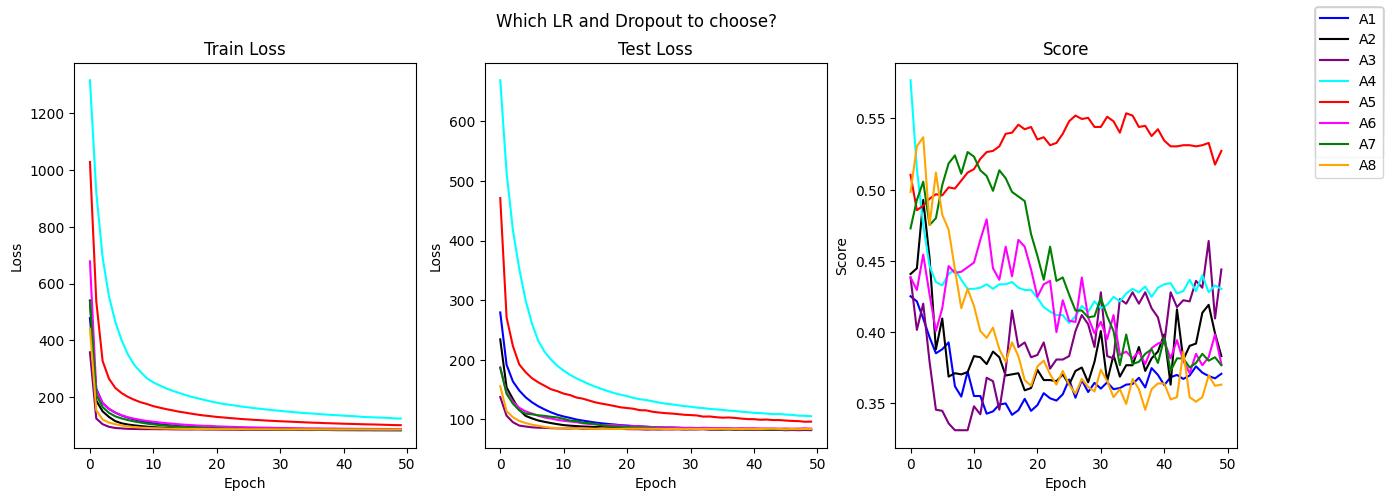

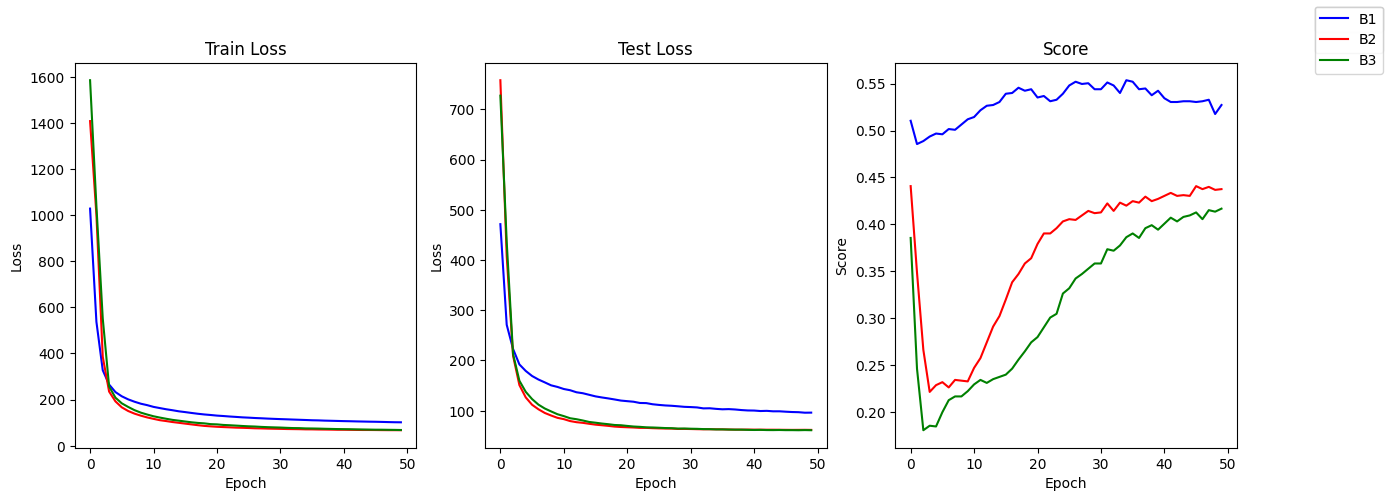

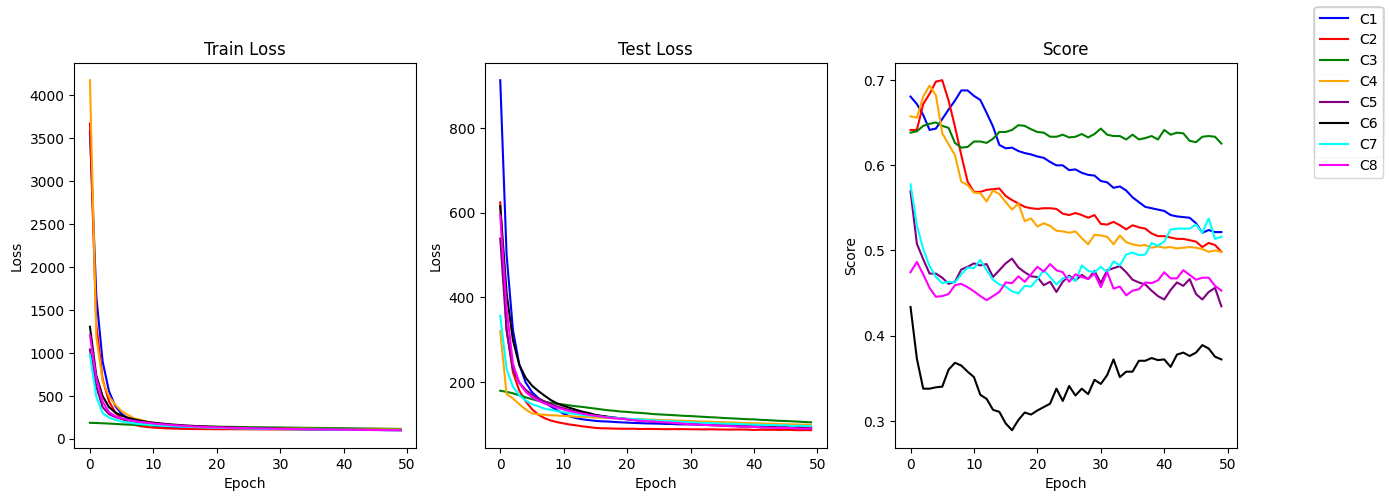

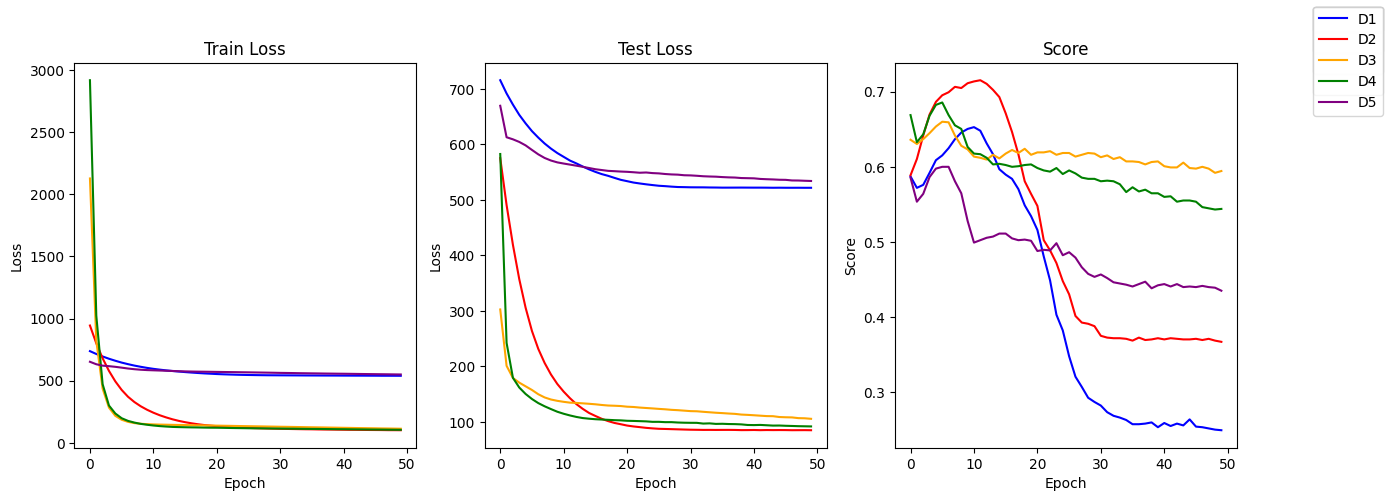

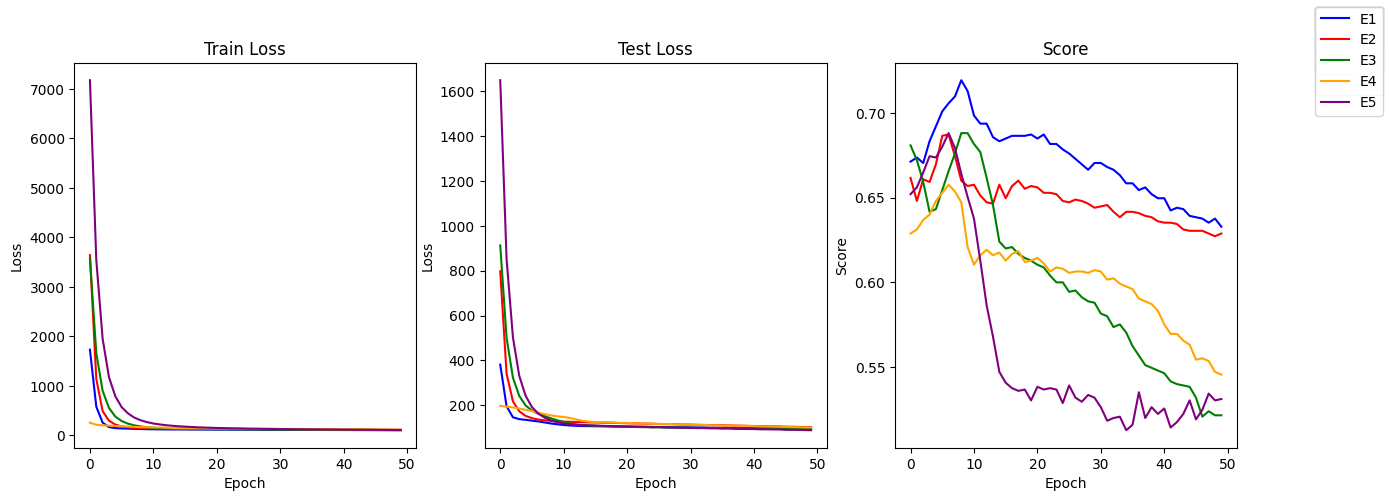

In [13]:
def plot_trajectories(fig, ax, test_index, color, label=None):
    av_train_loss = 0
    av_test_loss = 0
    av_score = 0
    for i in range(5):
        train_loss, test_loss, score = np.loadtxt(f'results_2d_autoencoder/test_{test_index}_iter_{i}.txt', unpack=True)
        av_train_loss += train_loss
        av_test_loss += test_loss
        av_score += score
        # ax[0].plot(train_loss, color=color, alpha=0.2)
        # ax[1].plot(test_loss, color=color, alpha=0.2)
        # ax[2].plot(score, color=color, alpha=0.2)
        ax[0].set_title('Train Loss')
        ax[1].set_title('Test Loss')
        ax[2].set_title('Score')
    ax[0].plot(av_train_loss/5, color=color, label=label)
    ax[1].plot(av_test_loss/5, color=color)
    ax[2].plot(av_score/5, color=color)
    ax[0].set_xlabel('Epoch')
    ax[1].set_xlabel('Epoch')
    ax[2].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[1].set_ylabel('Loss')
    ax[2].set_ylabel('Score')
    if label is not None:
        fig.legend()
    
fig,ax = plt.subplots(1,3, figsize=(15,5))
plot_trajectories(fig, ax, 1, 'blue', 'A1')
plot_trajectories(fig, ax, 6, 'black', 'A2')
plot_trajectories(fig, ax, 5, 'purple', 'A3')
plot_trajectories(fig, ax, 7, 'cyan', 'A4')
plot_trajectories(fig, ax, 2, 'red', 'A5')
plot_trajectories(fig, ax, 8, 'magenta', 'A6')
plot_trajectories(fig, ax, 3, 'green', 'A7')
plot_trajectories(fig, ax, 4, 'orange', 'A8')
fig.suptitle('Which LR and Dropout to choose?')
# ^ DO and lr tests --> DO and lr 0.001 seem to be the best
fig,ax = plt.subplots(1,3, figsize=(15,5))
plot_trajectories(fig, ax, 2, 'blue', 'B1')
plot_trajectories(fig, ax, 10, 'red', 'B2')
plot_trajectories(fig, ax, 12, 'green', 'B3')
# ^ Use all features
fig,ax = plt.subplots(1,3, figsize=(15,5))
plot_trajectories(fig, ax, 21, 'blue', 'C1')
plot_trajectories(fig, ax, 22, 'red', 'C2')
plot_trajectories(fig, ax, 23, 'green', 'C3')
plot_trajectories(fig, ax, 24, 'orange', 'C4')
plot_trajectories(fig, ax, 25, 'purple', 'C5')
plot_trajectories(fig, ax, 26, 'black', 'C6')
plot_trajectories(fig, ax, 27, 'cyan', 'C7')
plot_trajectories(fig, ax, 28, 'magenta', 'C8')
# ^ Different structures --> GCNConv 6531 seems to be the best
fig,ax = plt.subplots(1,3, figsize=(15,5))
plot_trajectories(fig, ax, 13, 'blue', 'D1')
plot_trajectories(fig, ax, 14, 'red', 'D2')
plot_trajectories(fig, ax, 16, 'orange', 'D3')
plot_trajectories(fig, ax, 15, 'green', 'D4')
plot_trajectories(fig, ax, 17, 'purple', 'D5')
# plot_trajectories(fig, ax, 18, 'black', 'GINEConv: attr sigmoid, str sigmoid')
# plot_trajectories(fig, ax, 9, 'cyan', 'GINEConv: attr sigmoid, str none')
# # Misses relu none
# plot_trajectories(fig, ax, 19, 'magenta', 'GINEConv: attr relu, str relu')
# plot_trajectories(fig, ax, 20, 'brown', 'GINEConv: attr relu, str sigmoid')
# ^ GCNConv and GINEConv tests --> GCNConv relu relu seems to be better
fig,ax = plt.subplots(1,3, figsize=(15,5))
plot_trajectories(fig, ax, 29, 'blue', r'E1')
plot_trajectories(fig, ax, 30, 'red', r'E2')
plot_trajectories(fig, ax, 21, 'green', r'E3')
plot_trajectories(fig, ax, 31, 'orange', r'E4')
plot_trajectories(fig, ax, 32, 'purple', r'E5')
# plot_trajectories(fig, ax, 33, 'black', r'GINEConv: $\alpha=0.3$')
# plot_trajectories(fig, ax, 34, 'cyan', r'GINEConv: $\alpha=0.4$')
# plot_trajectories(fig, ax, 25, 'magenta', r'GINEConv: $\alpha=0.5$')
# plot_trajectories(fig, ax, 35, 'brown', r'GINEConv: $\alpha=0.6$')
# plot_trajectories(fig, ax, 36, 'grey', r'GINEConv: $\alpha=0.7$')
# ^ Different alphas --> 0.3 seems to be the best

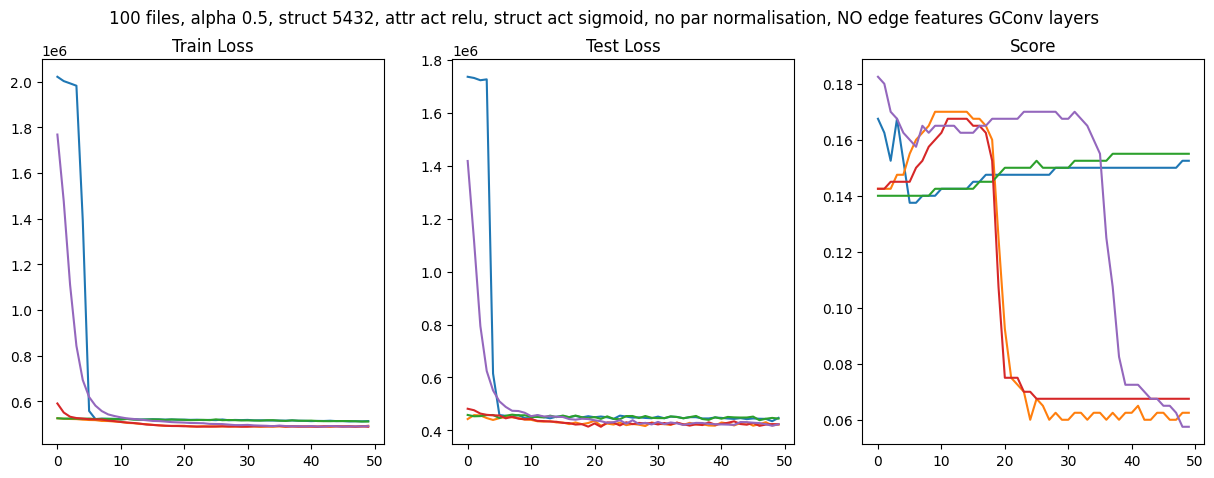

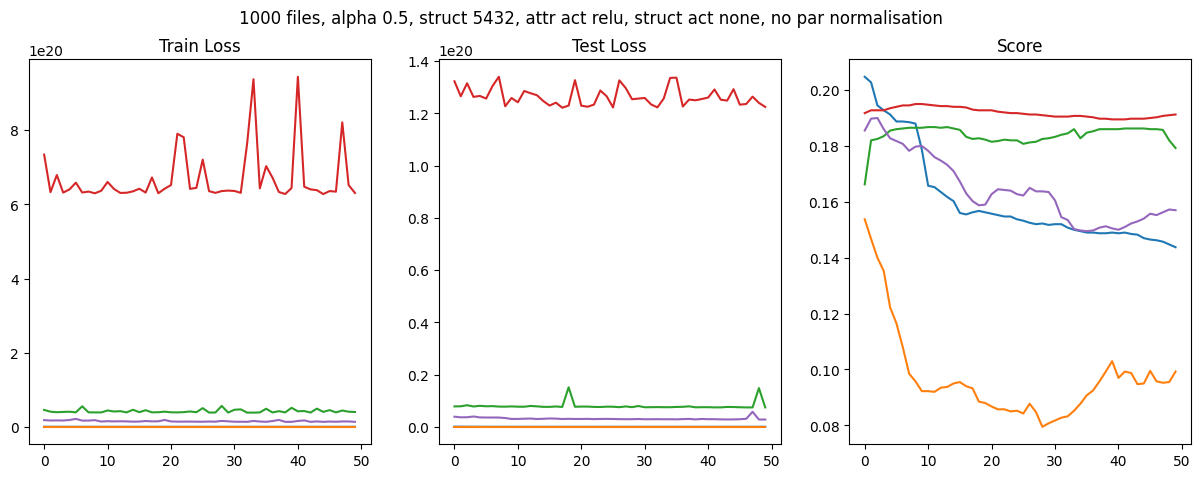

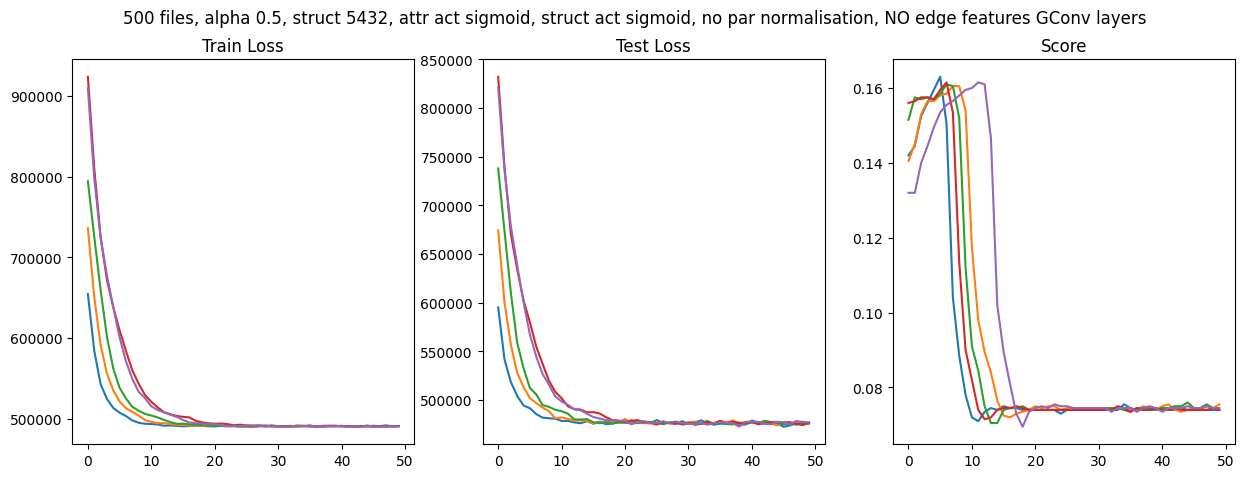

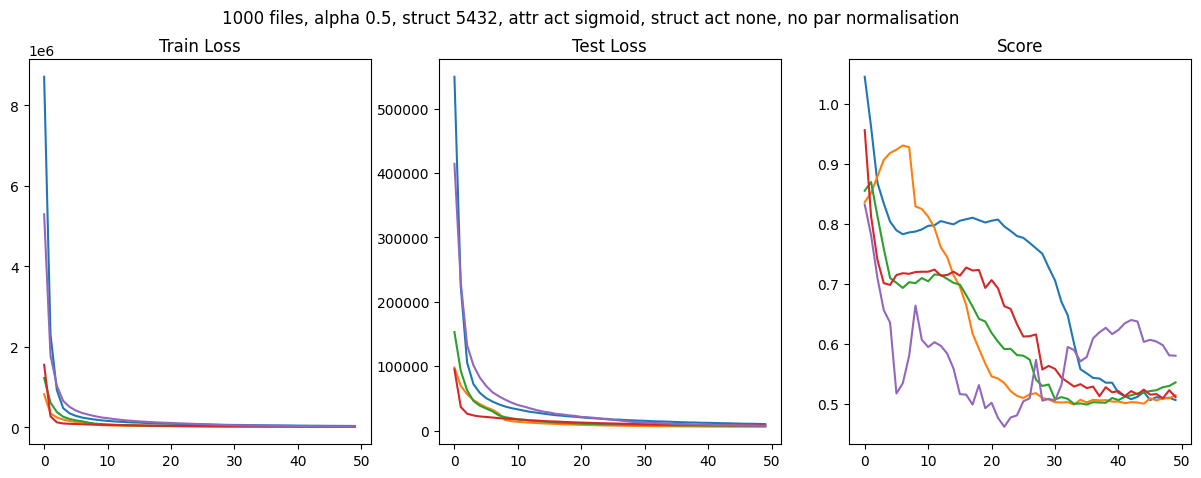

In [24]:
fig,ax = plt.subplots(ncols=3, figsize = (15,5))
for i in range(5):
    train_loss, test_loss, score = np.loadtxt(f'results_2d_autoencoder/test_1_iter_{i}.txt').T
    ax[0].plot(train_loss, label='Train Loss', color=cmap[i])
    ax[1].plot(test_loss, label='Test Loss', color=cmap[i])
    ax[2].plot(score, label='Score', color=cmap[i])
    ax[0].set_title('Train Loss')
    ax[1].set_title('Test Loss')
    ax[2].set_title('Score')
    fig.suptitle('100 files, alpha 0.5, struct 5432, attr act relu, struct act sigmoid, no par normalisation, NO edge features GConv layers')
    
fig,ax = plt.subplots(ncols=3, figsize = (15,5))
for i in range(5):
    train_loss, test_loss, score = np.loadtxt(f'2d_autoencoder_tests/test_2_iter_{i}.txt').T
    ax[0].plot(train_loss, label='Train Loss', color=cmap[i])
    ax[1].plot(test_loss, label='Test Loss', color=cmap[i])
    ax[2].plot(score, label='Score', color=cmap[i])
    ax[0].set_title('Train Loss')
    ax[1].set_title('Test Loss')
    ax[2].set_title('Score')
    fig.suptitle('1000 files, alpha 0.5, struct 5432, attr act relu, struct act none, no par normalisation')
    
fig,ax = plt.subplots(ncols=3, figsize = (15,5))
for i in range(5):
    train_loss, test_loss, score = np.loadtxt(f'2d_autoencoder_tests/test_3_iter_{i}.txt').T
    ax[0].plot(train_loss, label='Train Loss', color=cmap[i])
    ax[1].plot(test_loss, label='Test Loss', color=cmap[i])
    ax[2].plot(score, label='Score', color=cmap[i])
    ax[0].set_title('Train Loss')
    ax[1].set_title('Test Loss')
    ax[2].set_title('Score')
    fig.suptitle('500 files, alpha 0.5, struct 5432, attr act sigmoid, struct act sigmoid, no par normalisation, NO edge features GConv layers')
    
fig,ax = plt.subplots(ncols=3, figsize = (15,5))
for i in range(5):
    train_loss, test_loss, score = np.loadtxt(f'2d_autoencoder_tests/test_4_iter_{i}.txt').T
    ax[0].plot(train_loss, label='Train Loss', color=cmap[i])
    ax[1].plot(test_loss, label='Test Loss', color=cmap[i])
    ax[2].plot(score, label='Score', color=cmap[i])
    ax[0].set_title('Train Loss')
    ax[1].set_title('Test Loss')
    ax[2].set_title('Score')
    fig.suptitle('1000 files, alpha 0.5, struct 5432, attr act sigmoid, struct act none, no par normalisation')
    
# TODO: the scores from colab were calculated by dividing through len(train_loader.dataset) instead of len(test_loader.dataset) -> fix this
# TODO: score > 1 is not possible, check if the scores are calculated correctly